# Projet 7 : Implémentez un modèle de scoring

In [2]:
# Installation de MLFlow :
#!pip install mlflow

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, fbeta_score, make_scorer
)
import time
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV
import shap
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint
from scipy.stats import uniform
import joblib

In [259]:
data = pd.read_csv('df_final.csv')

In [260]:
data

,Unnamed: 0,SK_ID_CURR,TARGET,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCE_2,APP_SCORE2_TO_REGION_RATING_RATIO,EXT_SOURCE_3,APP_SCORE2_TO_BIRTH_RATIO,DAYS_EMPLOYED,...,CLOSED_DEBT_CREDIT_DIFF_MIN,HOUR_APPR_PROCESS_START,INSTAL_PAYMENT_DIFF_SUM,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,INSTAL_PAYMENT_PERC_MEAN,INS_D365INS_IS_DPD_UNDER_120_SUM,APPROVED_CNT_PAYMENT_SUM,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MEAN,CODE_GENDER
0,0,100002,1.0,0.08300,0.26300,0.26300,0.13150,0.13940,-0.010155,-637.0,...,0.00,10,0.000,-15.5,1.0000,0.0,24.0,1.0000,0.0000,0
1,1,100003,0.0,0.31130,0.62200,0.62200,0.62200,NaN,-0.013560,-1188.0,...,22248.00,11,0.000,-43.0,1.0000,NaN,30.0,0.8687,0.0000,1
2,2,100004,0.0,0.55600,0.72950,0.55600,0.27800,0.72950,-0.010660,-225.0,...,94500.00,9,0.000,NaN,1.0000,NaN,4.0,1.2080,0.0000,0
3,3,100006,0.0,0.65040,0.65040,0.65040,0.32520,NaN,-0.012500,-3040.0,...,121240.15,17,0.000,NaN,1.0000,0.0,90.0,0.7593,0.0000,1
4,4,100007,0.0,0.32280,0.32280,0.32280,0.16140,NaN,-0.005913,-3038.0,...,146250.00,11,29857.365,NaN,0.9546,0.0,124.0,0.7910,0.9546,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,307501,456251,0.0,0.14560,0.68160,0.68160,0.68160,NaN,-0.026690,-236.0,...,121240.15,15,0.000,NaN,1.0000,0.0,8.0,1.0000,0.0000,0
307502,307502,456252,0.0,0.11597,0.11597,0.11597,0.05798,NaN,-0.002039,NaN,...,121240.15,8,0.000,NaN,1.0000,NaN,6.0,1.0140,0.5000,1
307503,307503,456253,0.0,0.21890,0.74400,0.53560,0.17860,0.21890,-0.013080,-7920.0,...,675000.00,9,3973.095,-92.0,0.9287,NaN,10.0,1.0590,0.6430,1
307504,307504,456254,1.0,0.51400,0.66100,0.51400,0.25700,0.66100,-0.015700,-4784.0,...,45000.00,9,0.000,NaN,1.0000,0.0,30.0,0.8784,0.0000,1


In [261]:
# Supprimer la colonne 'Unnamed: 0'
data = data.drop(columns=['Unnamed: 0'])
data

,SK_ID_CURR,TARGET,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCE_2,APP_SCORE2_TO_REGION_RATING_RATIO,EXT_SOURCE_3,APP_SCORE2_TO_BIRTH_RATIO,DAYS_EMPLOYED,DAYS_BIRTH,...,CLOSED_DEBT_CREDIT_DIFF_MIN,HOUR_APPR_PROCESS_START,INSTAL_PAYMENT_DIFF_SUM,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,INSTAL_PAYMENT_PERC_MEAN,INS_D365INS_IS_DPD_UNDER_120_SUM,APPROVED_CNT_PAYMENT_SUM,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MEAN,CODE_GENDER
0,100002,1.0,0.08300,0.26300,0.26300,0.13150,0.13940,-0.010155,-637.0,-9461,...,0.00,10,0.000,-15.5,1.0000,0.0,24.0,1.0000,0.0000,0
1,100003,0.0,0.31130,0.62200,0.62200,0.62200,NaN,-0.013560,-1188.0,-16765,...,22248.00,11,0.000,-43.0,1.0000,NaN,30.0,0.8687,0.0000,1
2,100004,0.0,0.55600,0.72950,0.55600,0.27800,0.72950,-0.010660,-225.0,-19046,...,94500.00,9,0.000,NaN,1.0000,NaN,4.0,1.2080,0.0000,0
3,100006,0.0,0.65040,0.65040,0.65040,0.32520,NaN,-0.012500,-3040.0,-19005,...,121240.15,17,0.000,NaN,1.0000,0.0,90.0,0.7593,0.0000,1
4,100007,0.0,0.32280,0.32280,0.32280,0.16140,NaN,-0.005913,-3038.0,-19932,...,146250.00,11,29857.365,NaN,0.9546,0.0,124.0,0.7910,0.9546,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,456251,0.0,0.14560,0.68160,0.68160,0.68160,NaN,-0.026690,-236.0,-9327,...,121240.15,15,0.000,NaN,1.0000,0.0,8.0,1.0000,0.0000,0
307502,456252,0.0,0.11597,0.11597,0.11597,0.05798,NaN,-0.002039,NaN,-20775,...,121240.15,8,0.000,NaN,1.0000,NaN,6.0,1.0140,0.5000,1
307503,456253,0.0,0.21890,0.74400,0.53560,0.17860,0.21890,-0.013080,-7920.0,-14966,...,675000.00,9,3973.095,-92.0,0.9287,NaN,10.0,1.0590,0.6430,1
307504,456254,1.0,0.51400,0.66100,0.51400,0.25700,0.66100,-0.015700,-4784.0,-11961,...,45000.00,9,0.000,NaN,1.0000,0.0,30.0,0.8784,0.0000,1


In [265]:
# Supprimer les features corréeles à plus de 70%

def find_highly_correlated_columns(df_cleaned, threshold=0.7):
    # Extraire uniquement les colonnes numériques
    numeric_df = data.select_dtypes(include=[np.number])

    # Calculer la matrice de corrélation
    corr_matrix = numeric_df.corr()

    # Créer un masque pour la matrice de corrélation (pour éviter de doubler les paires)
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    # Appliquer le masque et extraire les corrélations supérieures au seuil
    high_corr_pairs = corr_matrix.where(mask).stack().reset_index()
    high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
    
    # Filtrer les paires ayant une corrélation absolue supérieure au seuil
    high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['Correlation'].abs() > threshold]
    
    return high_corr_pairs

# Utilisation de la fonction
correlated_columns = find_highly_correlated_columns(data)
print(correlated_columns)

                              Feature_1                          Feature_2  \
402                        EXT_SOURCE_2  APP_SCORE2_TO_REGION_RATING_RATIO   
404                        EXT_SOURCE_2          APP_SCORE2_TO_BIRTH_RATIO   
639                        EXT_SOURCE_3          APP_SCORE3_TO_BIRTH_RATIO   
1177          INSTAL_AMT_INSTALMENT_MAX         INS_D365AMT_INSTALMENT_MAX   
1521               PREV_AMT_ANNUITY_MAX               PREV_AMT_ANNUITY_SUM   
1620               INS_D365DPD_DIFF_MAX              INS_D365DPD_DIFF_MEAN   
1683            PREV_DAYS_DECISION_MEAN             PREV_DAYS_DECISION_MIN   
1712            PREV_DAYS_DECISION_MEAN             PREV_DAYS_DECISION_MAX   
2027              BURO_DAYS_CREDIT_MEAN               BURO_DAYS_CREDIT_MIN   
2063              BURO_DAYS_CREDIT_MEAN       BURO_DAYS_CREDIT_UPDATE_MEAN   
2282                ANNUITY_INCOME_PERC            APPS_GOODS_INCOME_RATIO   
2517          BURO_DEBT_CREDIT_DIFF_MAX          CLOSED_AMT_CRED

In [269]:
# Supprimer les features très corrélées (>70%)
def drop_correlated_features(data, correlated_columns):
    # Liste des colonnes à supprimer
    columns_to_drop = set()

    # Parcourir les paires de colonnes corrélées
    for index, row in correlated_columns.iterrows():
        # Ajouter la deuxième colonne de chaque paire à la liste de suppression
        # (on peut choisir de supprimer la première ou la deuxième colonne)
        columns_to_drop.add(row['Feature_2'])

    # Supprimer les colonnes corrélées de la DataFrame
    data_cleaned = data.drop(columns=columns_to_drop)

    return data_cleaned, columns_to_drop

# Utilisation de la fonction
data_cleaned, columns_dropped = drop_correlated_features(data, correlated_columns)

# Afficher les colonnes supprimées
print(f"Colonnes supprimées : {columns_dropped}")

# Afficher la DataFrame finale après suppression
print("DataFrame finale après suppression des features corrélées :")
data_cleaned

Colonnes supprimées : {'INS_D365INS_IS_DPD_UNDER_120_SUM', 'PREV_CNT_PAYMENT_MEAN', 'INSTAL_DPD_diff_MEAN', 'INSTAL_DPD_MEAN', 'CLOSED_AMT_CREDIT_SUM_MAX', 'AMT_INCOME_TOTAL', 'PREV_AMT_ANNUITY_SUM', 'PREV_DAYS_DECISION_MIN', 'BURO_ENDDATE_DIF_MAX', 'BURO_BUREAU_CREDIT_FACT_DIFF_MIN', 'PREV_CREDIT_TO_ANNUITY_RATIO_MAX', 'INS_D365AMT_INSTALMENT_SUM', 'BURO_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_UPDATE_MEAN', 'APP_SCORE2_TO_BIRTH_RATIO', 'APP_SCORE3_TO_BIRTH_RATIO', 'PREV_DAYS_DECISION_MAX', 'APP_SCORE2_TO_REGION_RATING_RATIO', 'APPS_GOODS_INCOME_RATIO', 'INS_D365DPD_DIFF_MEAN', 'PREV_APP_CREDIT_PERC_MIN', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_SUM_MAX', 'BURO_BUREAU_CREDIT_FACT_DIFF_MEAN', 'PREV_AMT_ANNUITY_MIN', 'AMT_ANNUITY', 'INS_D365AMT_INSTALMENT_MAX'}
DataFrame finale après suppression des features corrélées :


,SK_ID_CURR,TARGET,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,APPS_EXT_SOURCE_STD,DAYS_REGISTRATION,...,BURO_AMT_CREDIT_SUM_DEBT_MEAN,PREV_DAYS_LAST_DUE_DIFF_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_DEBT_CREDIT_DIFF_MIN,HOUR_APPR_PROCESS_START,INSTAL_PAYMENT_DIFF_SUM,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,INSTAL_PAYMENT_PERC_MEAN,APPROVED_CNT_PAYMENT_SUM,CODE_GENDER
0,100002,1.0,0.08300,0.26300,0.26300,0.13940,-637.0,-9461,0.09204,-3648.0,...,49156.20,150.0,1681.0290,0.00,10,0.000,-15.5,1.0000,24.0,0
1,100003,0.0,0.31130,0.62200,0.62200,NaN,-1188.0,-16765,0.21980,-1186.0,...,0.00,50.0,0.0000,22248.00,11,0.000,-43.0,1.0000,30.0,1
2,100004,0.0,0.55600,0.72950,0.55600,0.72950,-225.0,-19046,0.12280,-4260.0,...,0.00,30.0,0.0000,94500.00,9,0.000,NaN,1.0000,4.0,0
3,100006,0.0,0.65040,0.65040,0.65040,NaN,-3040.0,-19005,0.15100,-9830.0,...,161634.39,810.0,5004.9595,121240.15,17,0.000,NaN,1.0000,90.0,1
4,100007,0.0,0.32280,0.32280,0.32280,NaN,-3038.0,-19932,0.15100,-4310.0,...,0.00,7.5,0.0000,146250.00,11,29857.365,NaN,0.9546,124.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,456251,0.0,0.14560,0.68160,0.68160,NaN,-236.0,-9327,0.37920,-8456.0,...,161634.39,30.0,5004.9595,121240.15,15,0.000,NaN,1.0000,8.0,0
307502,456252,0.0,0.11597,0.11597,0.11597,NaN,NaN,-20775,0.15100,-4388.0,...,161634.39,0.0,5004.9595,121240.15,8,0.000,NaN,1.0000,6.0,1
307503,456253,0.0,0.21890,0.74400,0.53560,0.21890,-7920.0,-14966,0.26440,-6736.0,...,448958.25,0.0,5004.9595,675000.00,9,3973.095,-92.0,0.9287,10.0,1
307504,456254,1.0,0.51400,0.66100,0.51400,0.66100,-4784.0,-11961,0.10380,-2562.0,...,0.00,NaN,5004.9595,45000.00,9,0.000,NaN,1.0000,30.0,1


In [227]:
import pandas as pd

# Calculer la matrice de corrélation
correlation_matrix = data_cleaned.corr()

# Sélectionner uniquement les corrélations avec la cible 'TARGET'
target_corr = correlation_matrix['TARGET'].drop('TARGET').abs()

# Trier les features par ordre de corrélation décroissante avec la cible
most_correlated_features = target_corr.sort_values(ascending=False)

# Afficher les n features les plus corrélées avec la cible
n = 10  # par exemple, pour afficher les 10 plus corrélées
print(most_correlated_features.head(n))


EXT_SOURCES_MAX                      0.196866
EXT_SOURCES_MIN                      0.185259
EXT_SOURCE_3                         0.178905
EXT_SOURCE_2                         0.160451
BURO_DAYS_CREDIT_MEAN                0.089717
DAYS_BIRTH                           0.078235
DAYS_EMPLOYED                        0.074950
INSTAL_INS_IS_DPD_UNDER_120_MEAN     0.070535
CREDIT_TO_GOODS_RATIO                0.069411
INS_D365INS_IS_DPD_UNDER_120_MEAN    0.068852
Name: TARGET, dtype: float64


In [229]:
correlation_matrix

,SK_ID_CURR,TARGET,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,APPS_EXT_SOURCE_STD,DAYS_REGISTRATION,...,BURO_AMT_CREDIT_SUM_DEBT_MEAN,PREV_DAYS_LAST_DUE_DIFF_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_DEBT_CREDIT_DIFF_MIN,HOUR_APPR_PROCESS_START,INSTAL_PAYMENT_DIFF_SUM,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,INSTAL_PAYMENT_PERC_MEAN,APPROVED_CNT_PAYMENT_SUM,CODE_GENDER
SK_ID_CURR,1.000000,-0.002094,0.001487,0.000280,0.002333,0.000195,-0.000097,-0.001496,-0.001597,-0.000975,...,-0.000959,-0.003035,0.002335,-0.000540,0.000357,-0.002119,0.002297,-0.004704,0.000312,0.000739
TARGET,-0.002094,1.000000,-0.185259,-0.196866,-0.160451,-0.178905,0.074950,0.078235,0.044084,0.041982,...,-0.000546,0.035835,0.001853,-0.010670,-0.024171,0.026812,0.027351,0.001365,-0.008580,-0.054719
EXT_SOURCES_MIN,0.001487,-0.185259,1.000000,0.509756,0.662834,0.628463,-0.153346,-0.263975,-0.606885,-0.127112,...,-0.004785,-0.016231,-0.002397,0.034456,0.068764,-0.046508,-0.102932,-0.001774,0.020483,0.071749
EXT_SOURCES_MAX,0.000280,-0.196866,0.509756,1.000000,0.624952,0.581247,-0.157508,-0.216441,0.213523,-0.095632,...,-0.006754,0.002266,0.000925,0.025250,0.089707,-0.037790,-0.096813,-0.000972,0.042002,0.080984
EXT_SOURCE_2,0.002333,-0.160451,0.662834,0.624952,1.000000,0.109166,-0.093459,-0.092004,-0.226431,-0.059929,...,0.034997,0.014540,0.002578,0.031638,0.156859,-0.027864,-0.025814,-0.000440,0.015427,0.014620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INSTAL_PAYMENT_DIFF_SUM,-0.002119,0.026812,-0.046508,-0.037790,-0.027864,-0.047269,0.014132,0.030963,0.026202,0.003495,...,-0.000960,-0.179864,0.001927,-0.005525,-0.002696,1.000000,0.013175,-0.010046,-0.117662,-0.016239
ACTIVE_DAYS_CREDIT_UPDATE_MEAN,0.002297,0.027351,-0.102932,-0.096813,-0.025814,-0.163806,0.031578,0.075852,0.009068,0.041169,...,0.059689,0.010307,0.001783,0.019548,0.006984,0.013175,1.000000,0.001684,-0.034276,-0.022821
INSTAL_PAYMENT_PERC_MEAN,-0.004704,0.001365,-0.001774,-0.000972,-0.000440,-0.001571,0.001829,0.000890,0.001150,0.003904,...,0.003598,0.010915,-0.000102,-0.000533,-0.002240,-0.010046,0.001684,1.000000,0.005543,0.000849
APPROVED_CNT_PAYMENT_SUM,0.000312,-0.008580,0.020483,0.042002,0.015427,-0.004409,-0.094393,-0.178332,-0.000662,-0.051742,...,-0.021710,0.411158,-0.003388,-0.023545,-0.026900,-0.117662,-0.034276,0.005543,1.000000,0.077700


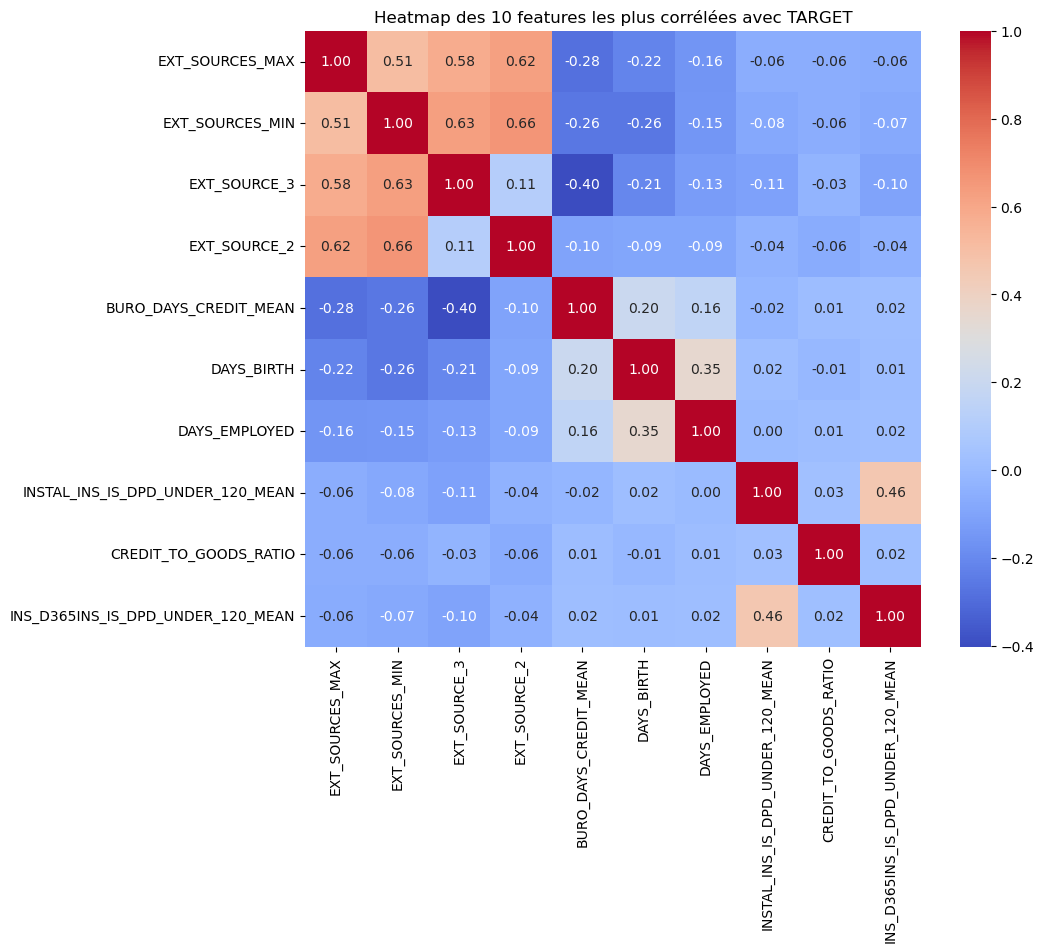

In [231]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de corrélation
correlation_matrix = data_cleaned.corr()

# Sélectionner uniquement les corrélations avec la cible 'TARGET'
target_corr = correlation_matrix['TARGET'].drop('TARGET').abs()

# Trier les features par ordre de corrélation décroissante avec la cible
n = 10  # nombre de features les plus corrélées à afficher
most_correlated_features = target_corr.sort_values(ascending=False).head(n).index

# Créer une matrice de corrélation réduite avec seulement les n features les plus corrélées avec 'TARGET'
reduced_corr_matrix = data_cleaned[most_correlated_features].corr()

# Afficher la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(reduced_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f'Heatmap des {n} features les plus corrélées avec TARGET')
plt.show()


In [271]:
# Définir X et y (ajustez les noms de colonnes selon votre DataFrame)
X = data_cleaned.drop(columns=['TARGET', 'SK_ID_CURR', 'CODE_GENDER'])  # Remplacez par le nom de votre colonne cible
y = data_cleaned['TARGET']  # Remplacez par le nom de votre colonne cible


In [273]:

# Vérifier les valeurs manquantes
print("Valeurs manquantes dans dat_cleaned :")
missing_values = data_cleaned.isnull().sum()
print(missing_values)

Valeurs manquantes dans dat_cleaned :
SK_ID_CURR                            0
TARGET                                0
EXT_SOURCES_MIN                     172
EXT_SOURCES_MAX                     172
EXT_SOURCE_2                        660
                                  ...  
INSTAL_PAYMENT_DIFF_SUM               0
ACTIVE_DAYS_CREDIT_UPDATE_MEAN    90361
INSTAL_PAYMENT_PERC_MEAN          15894
APPROVED_CNT_PAYMENT_SUM          17446
CODE_GENDER                           0
Length: 76, dtype: int64


In [275]:
# Calculer les pourcentages de valeurs manquantes
missing_percentage = (missing_values / len(X)) * 100

# Afficher les pourcentages de valeurs manquantes
print("\nPourcentage des valeurs manquantes dans X :")
print(missing_percentage)


Pourcentage des valeurs manquantes dans X :
SK_ID_CURR                         0.000000
TARGET                             0.000000
EXT_SOURCES_MIN                    0.055934
EXT_SOURCES_MAX                    0.055934
EXT_SOURCE_2                       0.214630
                                    ...    
INSTAL_PAYMENT_DIFF_SUM            0.000000
ACTIVE_DAYS_CREDIT_UPDATE_MEAN    29.385118
INSTAL_PAYMENT_PERC_MEAN           5.168680
APPROVED_CNT_PAYMENT_SUM           5.673385
CODE_GENDER                        0.000000
Length: 76, dtype: float64


In [277]:
# Définir le répertoire pour le tracking
mlflow.set_tracking_uri("file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/mlruns")  # Remplacez par votre chemin

In [279]:
# Créer une nouvelle expérience
experiment_name = "Mon_Experiment"  # Choisissez un nom pour votre expérience
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/142011389048118064', creation_time=1728565912066, experiment_id='142011389048118064', last_update_time=1728565912066, lifecycle_stage='active', name='Mon_Experiment', tags={}>

In [281]:
# Définir X et y (ajustez les noms de colonnes selon votre DataFrame)
X = data_cleaned.drop(columns=['TARGET', 'SK_ID_CURR', 'CODE_GENDER'])  # Remplacez par le nom de votre colonne cible
y = data_cleaned['TARGET']  # Remplacez par le nom de votre colonne cible


In [283]:
# Traitement des valeurs manquantes et infinies
# Remplacer les valeurs infinies par NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [285]:
# Imputer les valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [287]:
# Conversion en DataFrame pour conserver les colonnes
X = pd.DataFrame(X_imputed, columns=X.columns)

In [289]:
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [291]:
# Division des données en ensembles d'entraînement, de validation et de test
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [293]:
# Sauvegarder les données nettoyées et normalisées dans un nouveau fichier CSV
X_cleaned = pd.DataFrame(X_scaled, columns=X.columns)  # Convertir en DataFrame
X_cleaned['TARGET'] = y.values  # Ajouter la colonne cible pour conserver toutes les données
X_cleaned.to_csv('df_final_cleaned.csv', index=False)  # Sauvegarder sans l'index

print("Les données nettoyées et normalisées ont été sauvegardées dans 'df_final_cleaned.csv'.")

Les données nettoyées et normalisées ont été sauvegardées dans 'df_final_cleaned.csv'.


In [294]:
# Définition des métriques personnalisées
def custom_metric(y, y_pred):
    TP = np.sum((y == 1) & (y_pred == 1))
    FP = np.sum((y == 0) & (y_pred == 1))
    TN = np.sum((y == 0) & (y_pred == 0))
    FN = np.sum((y == 1) & (y_pred == 0))
    
    PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    FMI = np.sqrt(PPV * TPR)
    return FMI

def custom_metric_f2(y, y_pred):
    return fbeta_score(y, y_pred, beta=2)

custom_scorer = make_scorer(custom_metric, greater_is_better=True)
custom_scorer_f2 = make_scorer(custom_metric_f2, greater_is_better=True)

In [295]:
# Évaluation des modèles
def model_eval_score(model, Xval, yval):
    yval_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, yval_pred)
    print(f"Confusion Matrix:\n{conf_mat}")
    print(f'Accuracy score    : {accuracy_score(yval, yval_pred):.3}')
    print(f'Precision score   : {precision_score(yval, yval_pred):.3}')
    print(f'Recall score      : {recall_score(yval, yval_pred):.3}')
    print(f'F1 score          : {f1_score(yval, yval_pred):.3}')
    print(f'F2 score          : {fbeta_score(yval, yval_pred, beta=2):.3}')
    
    print(f'ROCAUC score      : {roc_auc_score(yval, yval_pred):.3}')
    print(f'Custom metric FMI : {custom_metric(yval, yval_pred):.3}')
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [296]:
# Entraînement et évaluation des modèles

def logistic_regression(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="Logistic Regression"):
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "Logistic Regression")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("Logistic Regression Results:")
        model_eval(model, X_val, y_val)

def random_forest(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="Random Forest"):
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "Random Forest")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("Random Forest Results:")
        model_eval(model, X_val, y_val)

def lightgbm_model(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="LightGBM"):
        model = lgb.LGBMClassifier()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "LightGBM")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("LightGBM Results:")
        model_eval(model, X_val, y_val)

In [297]:
# Comparaison avec un modèle de base (DummyClassifier)
def dummy_classifier(X_train, X_val, y_train, y_val):
    dummyCls = DummyClassifier(strategy='stratified')
    dummyCls.fit(X_train, y_train)
    
    print("Dummy Classifier Results:")
    model_eval(dummyCls, X_val, y_val)

2024/11/10 16:04:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression Results:
Confusion Matrix:
[[56432    86]
 [ 4899    85]]
Accuracy score    : 0.919
Precision score   : 0.497
Recall score      : 0.0171
F1 score          : 0.033
F2 score          : 0.0211
ROCAUC score      : 0.508
Custom metric FMI : 0.0921



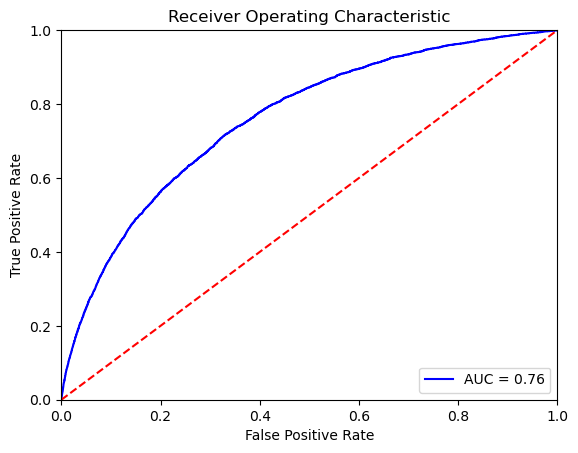

2024/11/10 16:16:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Results:
Confusion Matrix:
[[56472    46]
 [ 4931    53]]
Accuracy score    : 0.919
Precision score   : 0.535
Recall score      : 0.0106
F1 score          : 0.0209
F2 score          : 0.0132
ROCAUC score      : 0.505
Custom metric FMI : 0.0755



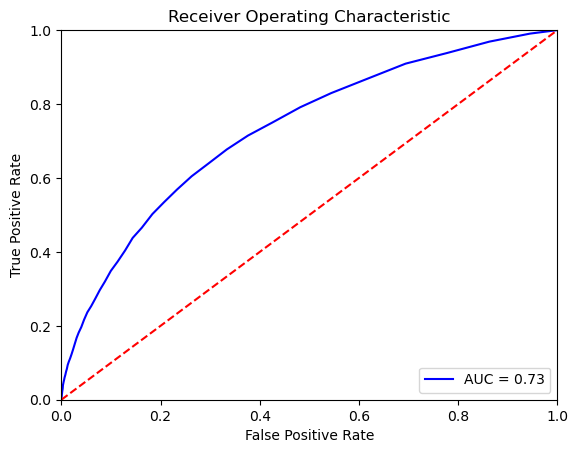

[LightGBM] [Info] Number of positive: 19840, number of negative: 226164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24116
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080649 -> initscore=-2.433560
[LightGBM] [Info] Start training from score -2.433560


2024/11/10 16:16:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM Results:
Confusion Matrix:
[[56376   142]
 [ 4823   161]]
Accuracy score    : 0.919
Precision score   : 0.531
Recall score      : 0.0323
F1 score          : 0.0609
F2 score          : 0.0398
ROCAUC score      : 0.515
Custom metric FMI : 0.131



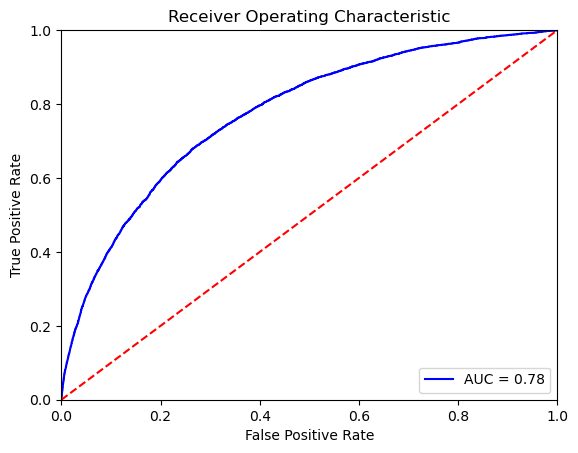

Dummy Classifier Results:
Confusion Matrix:
[[52008  4510]
 [ 4608   376]]
Accuracy score    : 0.852
Precision score   : 0.077
Recall score      : 0.0754
F1 score          : 0.0762
F2 score          : 0.0757
ROCAUC score      : 0.498
Custom metric FMI : 0.0762



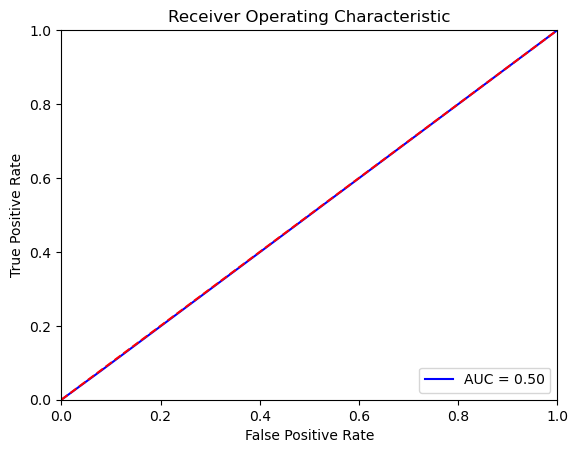

In [67]:
# Exécution des modèles
logistic_regression(X_train, X_val, y_train, y_val)
random_forest(X_train, X_val, y_train, y_val)
lightgbm_model(X_train, X_val, y_train, y_val)
dummy_classifier(X_train, X_val, y_train, y_val)


** Analyse des résultats **
**************

Les résultats des différents modèles montrent des performances globales qui peuvent être interprétées de plusieurs manières en fonction des métriques utilisées. Voici ce qu'on peut déduire de chaque modèle :

Logistic Regression Results :

Accuracy score : 0.919 — Cela indique que le modèle prédit correctement 91,9 % des observations. Cependant, l'accuracy seule peut être trompeuse dans les cas de déséquilibre des classes.

Precision : 0.497 — Cela signifie qu'environ 49,7 % des prédictions positives faites par le modèle sont correctes.

Recall : 0.0171 — La capacité du modèle à identifier les vrais positifs est très faible (1,71 %), ce qui est un problème important, surtout si l'on veut prédire correctement la classe positive.

F1 score : 0.033 — Cela montre que le modèle a une faible performance globale pour les classes positives, car le F1 score combine précision et rappel.

    ROCAUC : 0.508 — L'aire sous la courbe ROC est proche de 0,5, ce qui signifie que le modèle a des performances proches du hasard (aucune capacité de discrimination entre les classes).

Custom metric FMI : 0.0921 — Le FMI (Fowlkes-Mallows Index) indique une faible similarité entre les prédictions et les vraies classes, ce qui montre que le modèle a du mal à identifier les classes positives.

    Random Forest Results :

    Accuracy score : 0.919 — Tout comme la régression logistique, l'accuracy est élevée, mais cela ne reflète pas forcément de bonnes performances pour la classe minoritaire.

    Precision : 0.598 — Le modèle fait une prédiction correcte dans 59,8 % des cas pour les classes positives.

    Recall : 0.0104 — Le rappel est encore plus faible que celui de la régression logistique (1,04 %), ce qui signifie que le modèle manque pratiquement tous les vrais positifs.

    F1 score : 0.0205 — Comme le F1 score est basé sur à la fois la précision et le rappel, sa faible valeur indique que les performances globales pour les classes positives sont médiocres.

    ROCAUC : 0.505 — Comme pour la régression logistique, l'aire sous la courbe ROC est proche de 0,5, suggérant que le modèle n'a pas une grande capacité de discrimination entre les classes.

    Custom metric FMI : 0.079 — Le FMI est faible, ce qui indique une mauvaise performance globale du modèle sur cette tâche.

    LightGBM Results :

    Accuracy score : 0.919 — L'accuracy est identique à celle des autres modèles, mais elle ne suffit pas à évaluer correctement les performances du modèle sur les classes déséquilibrées.

    Precision : 0.531 — La précision est un peu plus élevée que celle des autres modèles (53,1 %), mais elle reste encore modeste.

    Recall : 0.0323 — Le rappel est très faible (3,23 %), indiquant que le modèle a du mal à identifier les instances positives.

F1 score : 0.0609 — Le faible F1 score indique une faible performance globale pour la classe positive.

ROCAUC : 0.515 — Encore une fois, l'aire sous la courbe ROC est proche de 0,5, indiquant que le modèle n'a pas une grande capacité à séparer les classes.

Custom metric FMI : 0.131 — Bien que ce soit plus élevé que dans les autres modèles, cela reste un score relativement faible, montrant que le modèle a encore des difficultés à identifier les classes positives.

Dummy Classifier Results :

Accuracy score : 0.853 — L'accuracy est plus faible, ce qui est normal pour un modèle de base qui fait des prédictions aléatoires. Cependant, il sert de point de référence pour évaluer les autres modèles.

Precision : 0.0821 — La précision est extrêmement faible, ce qui est attendu pour un modèle aléatoire.

Recall : 0.0799 — Le rappel est également faible, mais il est légèrement supérieur à celui de la précision, ce qui est typique d'un modèle aléatoire.

F1 score : 0.081 — Le faible F1 score montre que le modèle ne fait pas de bonnes prédictions, en particulier pour la classe positive.

ROCAUC : 0.501 — Comme pour les autres modèles, l'aire sous la courbe ROC est proche de 0,5, ce qui suggère que ce modèle aléatoire n'a pas de véritable pouvoir discriminant.

Custom metric FMI : 0.081 — Le FMI est très faible, ce qui est attendu pour un modèle aléatoire.

Principales Conclusions :

Problème de déséquilibre des classes : Tous les modèles ont des performances médiocres pour la classe positive. Les faibles scores de rappel et de F1 indiquent qu'il est difficile pour ces modèles de prédire correctement la classe minoritaire (probablement une classe positive dans un problème de classification déséquilibrée).

L'accuracy est trompeuse : Bien que l'accuracy semble élevée (environ 91 %), cela peut être dû à un déséquilibre des classes, où la majorité des prédictions sont pour la classe négative (dominante), ce qui fausse les performances globales.

ROCAUC faible : Tous les modèles ont des scores ROC AUC proches de 0.5, ce qui suggère que les modèles ont une capacité limitée à séparer les classes.

Précision et Rappel faibles : Les faibles valeurs de rappel et de précision montrent que les modèles sont incapables de détecter efficacement la classe positive, et leur capacité à identifier les vrais positifs est très faible.

Dummy Classifier : Les résultats du modèle de base (Dummy Classifier) sont bien pire que ceux des modèles plus complexes, ce qui confirme que les modèles plus sophistiqués apportent une certaine valeur, bien qu'ils ne soient pas très performants sur ce problème.

Actions possibles :

Rééchantillonnage des classes (SMOTE, sous-échantillonnage, etc.) : Étant donné le faible rappel pour la classe positive, l'utilisation de méthodes comme le rééchantillonnage ou des ajustements de poids de classe pourrait améliorer la capacité des modèles à identifier correctement les classes minoritaires.

In [95]:
# Équilibrage des classes avec SMOTE

# Fonction pour équilibrer les classes
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [97]:
# Définition de la fonction de coût métier

# Fonction de coût métier
def business_cost_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    return 10 * FN + FP  # Coût métier

# Création du score de coût métier
business_cost_scorer = make_scorer(business_cost_score, greater_is_better=False)

In [99]:
# Exécution des modèles avec suivi des résultats

# Exécuter les modèles avec suivi MLflow
def run_models(X_train, X_val, y_train, y_val):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "LightGBM": lgb.LGBMClassifier(),
        "Dummy Classifier": DummyClassifier(strategy='most_frequent')
    }
    
    for model_name, model in models.items():
        with mlflow.start_run():
            # Balancer les classes
            X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)
            
            # Entraîner le modèle
            model.fit(X_train_balanced, y_train_balanced)
            
            # Prédictions
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            # Calcul des scores
            auc = roc_auc_score(y_val, y_pred_proba)
            cost_score = business_cost_score(y_val, y_pred)
            
            # Logging des résultats dans MLflow
            mlflow.log_param("model_name", model_name)
            mlflow.log_metric("AUC", auc)
            mlflow.log_metric("Business Cost", cost_score)
            mlflow.sklearn.log_model(model, "model")
            
            print(f"{model_name} - AUC: {auc:.4f}, Business Cost: {cost_score:.4f}")

# Appel de la fonction avec vos données
run_models(X_train, X_val, y_train, y_val)

2024/11/09 07:13:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - AUC: 0.7552, Business Cost: 33035.0000


2024/11/09 07:28:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - AUC: 0.7315, Business Cost: 44926.0000
[LightGBM] [Info] Number of positive: 226164, number of negative: 226164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25749
[LightGBM] [Info] Number of data points in the train set: 452328, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2024/11/09 07:29:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM - AUC: 0.7463, Business Cost: 48386.0000


2024/11/09 07:29:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dummy Classifier - AUC: 0.5000, Business Cost: 49840.0000


** Interprétation **
**********
  
  Les résultats des modèles indiquent des informations sur leurs performances en termes d'AUC (Area Under the Curve) et de Business Cost. Voici ce que nous pouvons en déduire :

Logistic Regression - AUC: 0.7553, Business Cost: 33028.0000

AUC (0.7553) : Un score AUC supérieur à 0.7 est généralement considéré comme bon. Cela signifie que la régression logistique a une capacité relativement bonne à discriminer entre les classes positives et négatives, bien qu'il y ait probablement un certain déséquilibre des classes (car l'AUC n'est pas parfait).

Business Cost (33028) : Cela représente le coût associé à l'utilisation de ce modèle, probablement en fonction des erreurs de classification (faux positifs et faux négatifs). Le coût ici est relativement faible, ce qui peut indiquer que le modèle est efficace dans la gestion des erreurs coûteuses.

Random Forest - AUC: 0.7321, Business Cost: 45211.0000

AUC (0.7321) : Le score AUC est légèrement inférieur à celui de la régression logistique, mais reste au-dessus de 0.7, ce qui montre une capacité raisonnable à séparer les classes. Cependant, comparé à la régression logistique, le modèle Random Forest a peut-être un peu plus de mal à discriminer.

Business Cost (45211) : Le coût est plus élevé que celui de la régression logistique, ce qui pourrait signifier que ce modèle produit davantage d'erreurs qui ont un impact économique plus important (plus de faux positifs ou faux négatifs coûteux).

LightGBM - AUC: 0.7456, Business Cost: 48374.0000

AUC (0.7456) : L'AUC de LightGBM est légèrement plus élevé que celui des autres modèles, indiquant que ce modèle est légèrement meilleur en termes de capacité de discrimination entre les classes positives et négatives.

Business Cost (48374) : Le coût ici est le plus élevé, ce qui suggère que, bien que LightGBM offre une meilleure capacité de discrimination (AUC plus élevé), il semble faire des erreurs plus coûteuses en termes d'impact économique. Cela pourrait être lié à un biais dans le modèle qui conduit à plus de faux positifs ou de faux négatifs qui sont plus coûteux dans le contexte commercial.

Dummy Classifier - AUC: 0.5000, Business Cost: 49840.0000

AUC (0.5000) : L'AUC de 0.5 est typique d'un modèle aléatoire, ce qui signifie que ce modèle n'a aucune capacité réelle à discriminer entre les classes et effectue des prédictions au hasard.

Business Cost (49840) : Le coût est le plus élevé parmi tous les modèles, ce qui est attendu pour un modèle aléatoire, car il fait beaucoup d'erreurs coûteuses.

Comparaison et Conclusions :

Logistic Regression est le modèle le plus efficace en termes de coût commercial, avec une AUC décente de 0.7553 et un coût relativement bas (33028). Cela en fait un bon choix pour une utilisation dans des environnements où le coût des erreurs est important.

LightGBM présente le meilleur score AUC (0.7456), mais le coût commercial est plus élevé (48374), ce qui suggère que le modèle pourrait être plus précis, mais qu'il génère des erreurs plus coûteuses. Cela pourrait signifier qu'il faut ajuster certains paramètres ou réévaluer le seuil de classification pour réduire les erreurs coûteuses.

Random Forest est un compromis entre la régression logistique et LightGBM, avec une AUC de 0.7321 et un coût de 45211. Il pourrait offrir un bon équilibre entre la capacité de discrimination et le coût des erreurs.

Dummy Classifier est un modèle de référence aléatoire, avec une AUC de 0.5 et le coût le plus élevé, ce qui montre qu'il n'est pas une option viable pour résoudre ce problème.

Recommandations :

Si l'objectif principal est de minimiser les erreurs coûteuses, la régression logistique pourrait être le modèle à privilégier, bien qu'il y ait un petit compromis en termes de capacité de discrimination par rapport à LightGBM.

Si la précision est plus importante, LightGBM pourrait être exploré davantage, mais il serait utile d'optimiser le seuil de classification pour réduire les erreurs coûteuses.

Random Forest pourrait être utilisé comme un compromis, mais nécessite probablement un ajustement fin des paramètres pour mieux gérer les erreurs coûteuses.

Dans tous les cas, il serait judicieux de réévaluer les coûts associés aux faux positifs et faux négatifs et d'explorer des méthodes de rééchantillonnage ou des ajustements de seuil pour réduire les erreurs les plus coûteuses.

In [303]:
import pandas as pd
import time
import mlflow
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, make_scorer, confusion_matrix, accuracy_score, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [305]:
# Scorers personnalisés
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
f1_scorer = make_scorer(f1_score)

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [307]:
# Dictionnaire pour stocker les temps de traitement
time_results = {}

# Préparer un échantillon de 20% des données
X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=0.20, random_state=42)

# Fonction de coût métier
def business_cost_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Fonction modifiée pour inclure l'Accuracy et le coût métier
def run_model(grid_search, model_name):
    with mlflow.start_run():
        # Mesurer le temps d'entraînement
        start_fit = time.time()
        grid_search.fit(X_sampled, y_sampled)  # Entraînement sur l'échantillon
        end_fit = time.time()
        fit_time = end_fit - start_fit
        time_results[f'{model_name} - Fit Time'] = fit_time

        # Mesurer le temps de prédiction
        start_predict = time.time()
        y_pred = grid_search.predict(X_val)
        end_predict = time.time()
        predict_time = end_predict - start_predict
        time_results[f'{model_name} - Predict Time'] = predict_time

        # Calcul du coût métier
        business_cost = business_cost_score(y_val, y_pred)
        
        # Calcul des métriques supplémentaires
        auc_score = grid_search.best_score_
        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)

        # Log hyperparameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Business Cost", business_cost)
        mlflow.log_metric("Fit_Time_s", fit_time)
        mlflow.log_metric("Predict_Time_s", predict_time)

        # Save model
        mlflow.sklearn.log_model(grid_search.best_estimator_, model_name)

    return business_cost, auc_score, f1, accuracy  # Retourner aussi l'Accuracy

In [309]:
# Préparer les noms de colonnes pour un format valide
X_sampled.columns = X_sampled.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)

In [311]:
# Définir le modèle de régression logistique
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Pipeline avec SMOTE et régression logistique
pipeline_logistic = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', logistic_model)
])

# Paramètres à tester pour la régression logistique
param_grid_logistic = {
    'classifier__C': [0.1, 1],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100],
    'classifier__class_weight': ['balanced', None]
}

# Configuration de GridSearchCV pour la régression logistique avec SMOTE
grid_search_logistic = GridSearchCV(
    estimator=pipeline_logistic,
    param_grid=param_grid_logistic,
    scoring={'AUC': 'roc_auc', 'f1': f1_scorer},
    refit='AUC',
    cv=2,
    verbose=1,
    n_jobs=-1
)

In [313]:
# Définir le modèle Random Forest avec SMOTE
rf_model = RandomForestClassifier(random_state=42)
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', rf_model)
])

# Paramètres à tester pour Random Forest
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__class_weight': ['balanced', None],
    'classifier__min_samples_split': [5, 10]
}

# Configuration de GridSearchCV pour Random Forest
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring={'AUC': auc_scorer, 'f1': f1_scorer},
    refit='AUC',
    cv=2,
    verbose=1,
    n_jobs=-1
)


In [63]:
# Définir le modèle LightGBM avec SMOTE
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt',
                               num_leaves=31,
                               max_depth=-1,
                               learning_rate=0.1,
                               n_estimators=100,
                               subsample_for_bin=200000,
                               objective=None,
                               is_unbalance=True,
                               min_split_gain=0.0,
                               min_child_weight=0.001,
                               min_child_samples=20,
                               subsample=1.0,
                               subsample_freq=0,
                               colsample_bytree=1.0,
                               reg_alpha=0.0,
                               reg_lambda=0.0,
                               random_state=None,
                               n_jobs=-1,
                               importance_type='split')

# Création du pipeline avec SMOTE et LightGBM
pipeline_lgb = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', lgb_model)
])

# Paramètres à tester pour LightGBM
param_grid_lgb = {
    'classifier__num_leaves': [31],  # Testez différentes valeurs pour num_leaves
    'classifier__learning_rate': [0.1],  # Différentes valeurs de taux d'apprentissage
    'classifier__n_estimators': [50],  # Testez plusieurs valeurs pour n_estimators
    'classifier__max_depth': [-1],  # Différentes profondeurs d'arbres
    'classifier__min_split_gain': [0.1],  # Paramètre de gain minimal de séparation
    'classifier__min_child_weight': [0.01],  # Poids minimal des enfants
    'classifier__min_child_samples': [10],  # Taille minimale des échantillons d'enfants
    'classifier__subsample': [1.0],  # Sous-échantillonnage des données
    'classifier__subsample_freq': [1],  # Fréquence de sous-échantillonnage
    'classifier__colsample_bytree': [1],  # Fraction des colonnes utilisées par arbre
    'classifier__reg_alpha': [0.1],  # Regularisation L1
    'classifier__reg_lambda': [0.1]  # Regularisation L2
}

# Configuration de GridSearchCV pour LightGBM
grid_search_lgb = GridSearchCV(estimator=pipeline_lgb,
                               param_grid=param_grid_lgb,
                               scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                               refit='AUC',  # Utiliser l'AUC pour le meilleur modèle
                               cv=5,  # Utiliser 2-fold cross-validation
                               verbose=1,
                               n_jobs=-1)  # Utilisation de tous les cœurs pour le calcul

In [315]:
# Définir le Dummy Classifier avec SMOTE
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
pipeline_dummy = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', dummy_model)
])

# Paramètres à tester pour Dummy Classifier
param_grid_dummy = {
    'classifier__strategy': ['most_frequent', 'stratified', 'uniform']
}

# Configuration de GridSearchCV pour Dummy Classifier
grid_search_dummy = GridSearchCV(
    estimator=pipeline_dummy,
    param_grid=param_grid_dummy,
    scoring={'AUC': auc_scorer, 'f1': f1_scorer},
    refit='AUC',
    cv=2,
    verbose=1,
    n_jobs=-1
)

In [321]:
# Lancer les différents modèles et stocker les coûts métiers  
cost_logistic = run_model(grid_search_logistic, "Logistic Regression")
cost_rf = run_model(grid_search_rf, "Random Forest")
cost_lgb = run_model(grid_search_lgb, "LightGBM")
cost_dummy = run_model(grid_search_dummy, "Dummy Classifier")

Fitting 2 folds for each of 4 candidates, totalling 8 fits


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
2024/11/12 11:43:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fitting 2 folds for each of 16 candidates, totalling 32 fits


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
2024/11/12 11:49:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 56511, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18615
[LightGBM] [Info] Number of data points in the train set: 113022, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2024/11/12 11:50:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fitting 2 folds for each of 3 candidates, totalling 6 fits


2024/11/12 11:50:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [323]:
# Affichage de la courbe AUC pour chaque modèle
def plot_auc_curve(model, X_val, y_val, model_name):
    y_val_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


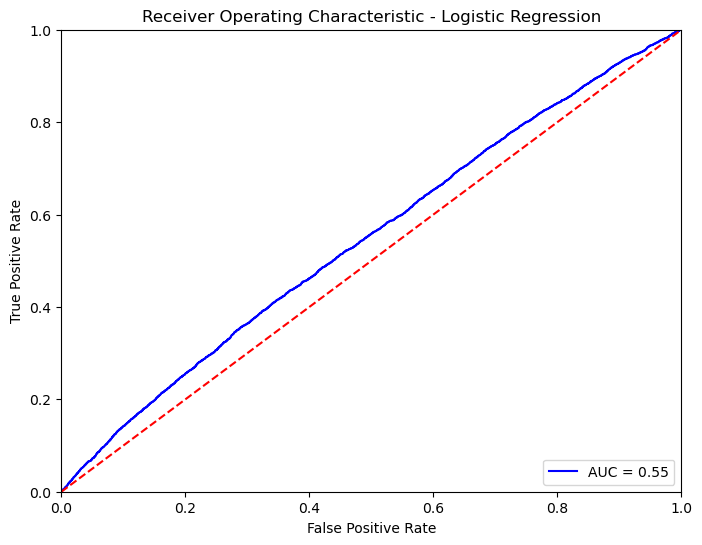

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


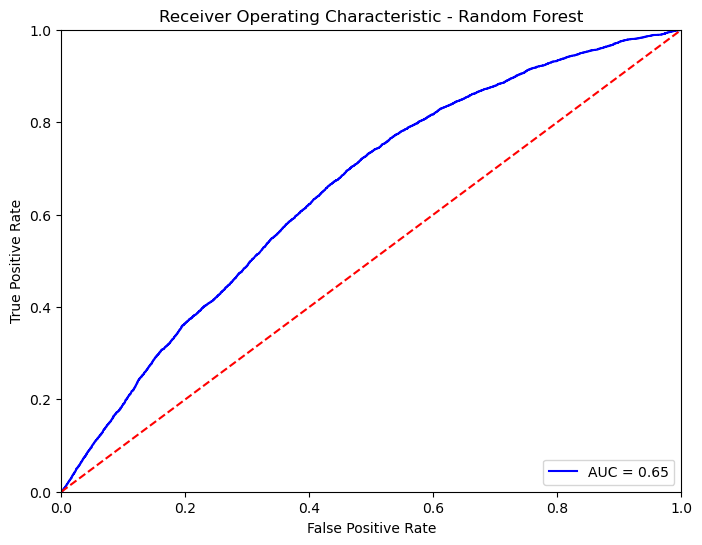

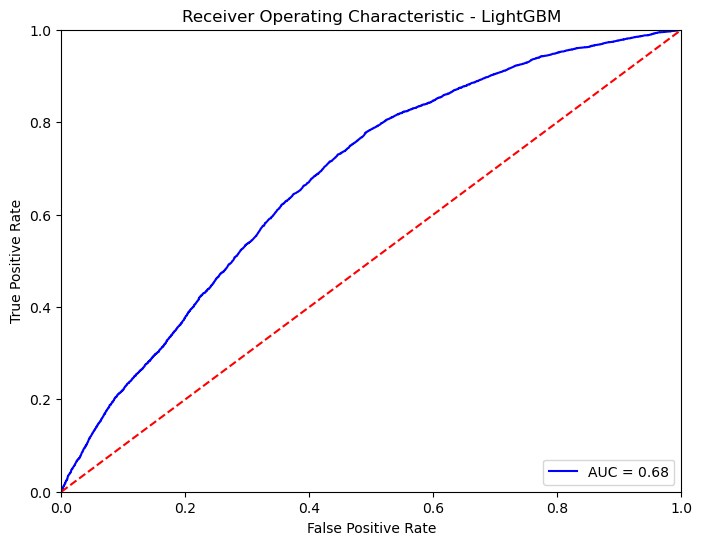

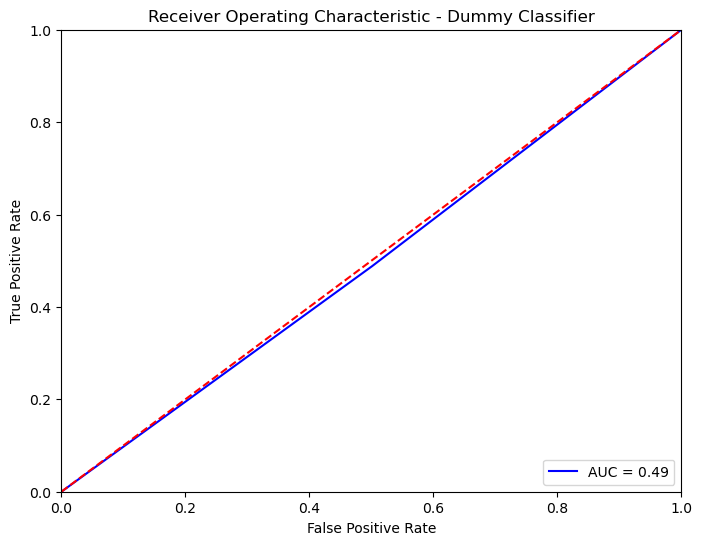

In [325]:
# Afficher la courbe AUC pour chaque modèle
plot_auc_curve(grid_search_logistic.best_estimator_, X_val, y_val, "Logistic Regression")
plot_auc_curve(grid_search_rf.best_estimator_, X_val, y_val, "Random Forest")
plot_auc_curve(grid_search_lgb.best_estimator_, X_val, y_val, "LightGBM")
plot_auc_curve(grid_search_dummy.best_estimator_, X_val, y_val, "Dummy Classifier")


In [327]:
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM', 'Dummy Classifier'],
    'Best AUC': [
        grid_search_logistic.best_score_,
        grid_search_rf.best_score_,
        grid_search_lgb.best_score_,
        grid_search_dummy.best_score_
    ],
    'Best F1 Score': [
        f1_score(y_val, grid_search_logistic.predict(X_val)),
        f1_score(y_val, grid_search_rf.predict(X_val)),
        f1_score(y_val, grid_search_lgb.predict(X_val)),
        f1_score(y_val, grid_search_dummy.predict(X_val))
    ],
    'Accuracy': [
        accuracy_score(y_val, grid_search_logistic.predict(X_val)),
        accuracy_score(y_val, grid_search_rf.predict(X_val)),
        accuracy_score(y_val, grid_search_lgb.predict(X_val)),
        accuracy_score(y_val, grid_search_dummy.predict(X_val))
    ],
    'Business Cost': [
        cost_logistic[0],
        cost_rf[0],
        cost_lgb[0],
        cost_dummy[0]
    ],
    'Fit Time (s)': [
        time_results['Logistic Regression - Fit Time'],
        time_results['Random Forest - Fit Time'],
        time_results['LightGBM - Fit Time'],
        time_results['Dummy Classifier - Fit Time']
    ],
    'Predict Time (s)': [
        time_results['Logistic Regression - Predict Time'],
        time_results['Random Forest - Predict Time'],
        time_results['LightGBM - Predict Time'],
        time_results['Dummy Classifier - Predict Time']
    ]
}

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results)
results_df


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Model,Best AUC,Best F1 Score,Accuracy,Business Cost,Fit Time (s),Predict Time (s)
0,Logistic Regression,0.647041,0.154621,0.563152,49610,224.868426,0.009357
1,Random Forest,0.716883,0.146478,0.861484,46796,402.185834,0.427655
2,LightGBM,0.701672,0.069525,0.908605,48587,10.561499,0.050950
3,Dummy Classifier,0.504151,0.136182,0.497724,53832,1.075544,0.004001


In [127]:
!pip install optuna

In [77]:
import optuna
from lightgbm import LGBMClassifier

# Définir la fonction d'objectif pour Optuna
def objective(trial):
    # Hyperparamètres à optimiser
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5)
    }
    
    # Initialiser le modèle
    model = LGBMClassifier(**params, is_unbalance=True)
    
    with mlflow.start_run():
        # Mesurer le temps d'entraînement
        start_fit = time.time()
        model.fit(X_sampled, y_sampled)
        end_fit = time.time()
        fit_time = end_fit - start_fit

        # Mesurer le temps de prédiction
        start_predict = time.time()
        y_pred = model.predict(X_val)
        end_predict = time.time()
        predict_time = end_predict - start_predict

        # Calculer le coût métier
        business_cost = business_cost_score(y_val, y_pred)
        
        # Calculer d'autres métriques
        auc_score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)

        # Enregistrer les paramètres et les métriques avec MLflow
        mlflow.log_params(params)
        mlflow.log_metric("Business Cost", business_cost)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Fit_Time_s", fit_time)
        mlflow.log_metric("Predict_Time_s", predict_time)

        # Enregistrer le modèle
        mlflow.sklearn.log_model(model, "lightgbm_model")

    return business_cost  # Objectif de minimisation

# Configurer Optuna pour minimiser le coût métier
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Afficher les meilleurs paramètres et le coût métier minimal
print("Best parameters:", study.best_params)
print("Minimum Business Cost:", study.best_value)

[I 2024-11-12 10:06:12,791] A new study created in memory with name: no-name-0995b09e-b8f7-43a3-a368-a0b537e4281c


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

2024/11/12 10:06:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:06:22,693] Trial 0 finished with value: 49813.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.17088784541819418, 'n_estimators': 76, 'max_depth': 9, 'subsample': 0.9221760445979521, 'colsample_bytree': 0.9230350813979908, 'reg_alpha': 0.24071860341423185, 'reg_lambda': 0.05303772267669554}. Best is trial 0 with value: 49813.0.


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2024/11/12 10:06:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:06:32,686] Trial 1 finished with value: 46207.0 and parameters: {'num_leaves': 52, 'learning_rate': 0.14572648131448795, 'n_estimators': 113, 'max_depth': 10, 'subsample': 0.9580654365768352, 'colsample_bytree': 0.8356367976271661, 'reg_alpha': 0.41333769013642363, 'reg_lambda': 0.00851378463993524}. Best is trial 1 with value: 46207.0.


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999


2024/11/12 10:06:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:06:43,328] Trial 2 finished with value: 43295.0 and parameters: {'num_leaves': 82, 'learning_rate': 0.06029378813284947, 'n_estimators': 125, 'max_depth': 13, 'subsample': 0.8285978277014261, 'colsample_bytree': 0.7385186033482831, 'reg_alpha': 0.4653660815399739, 'reg_lambda': 0.3745914658852452}. Best is trial 2 with value: 43295.0.


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999


2024/11/12 10:06:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:06:53,874] Trial 3 finished with value: 49841.0 and parameters: {'num_leaves': 39, 'learning_rate': 0.1751116633915786, 'n_estimators': 138, 'max_depth': 14, 'subsample': 0.9131045445276411, 'colsample_bytree': 0.8636801581491135, 'reg_alpha': 0.4963948603986017, 'reg_lambda': 0.35164133340316367}. Best is trial 2 with value: 43295.0.


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2024/11/12 10:07:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:07:05,874] Trial 4 finished with value: 45199.0 and parameters: {'num_leaves': 65, 'learning_rate': 0.16905336060495182, 'n_estimators': 192, 'max_depth': 10, 'subsample': 0.7351935009619646, 'colsample_bytree': 0.7905001485918363, 'reg_alpha': 0.463239496646824, 'reg_lambda': 0.31407299699025737}. Best is trial 2 with value: 43295.0.


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2024/11/12 10:07:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:07:17,595] Trial 5 finished with value: 49173.0 and parameters: {'num_leaves': 93, 'learning_rate': 0.13459699350585858, 'n_estimators': 124, 'max_depth': 10, 'subsample': 0.7577451050065283, 'colsample_bytree': 0.8152214641871411, 'reg_alpha': 0.01774728768426742, 'reg_lambda': 0.15216852486936921}. Best is trial 2 with value: 43295.0.


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

2024/11/12 10:07:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:07:28,071] Trial 6 finished with value: 49750.0 and parameters: {'num_leaves': 48, 'learning_rate': 0.13209191546934407, 'n_estimators': 152, 'max_depth': 6, 'subsample': 0.9961837184169045, 'colsample_bytree': 0.7013161006558247, 'reg_alpha': 0.04903036629259733, 'reg_lambda': 0.026635348135252923}. Best is trial 2 with value: 43295.0.


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

2024/11/12 10:07:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:07:39,057] Trial 7 finished with value: 45724.0 and parameters: {'num_leaves': 83, 'learning_rate': 0.05070983480537583, 'n_estimators': 137, 'max_depth': 5, 'subsample': 0.8834781046051375, 'colsample_bytree': 0.7015850575864134, 'reg_alpha': 0.1794336206052234, 'reg_lambda': 0.2441827494873381}. Best is trial 2 with value: 43295.0.


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999


2024/11/12 10:07:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:07:49,541] Trial 8 finished with value: 46159.0 and parameters: {'num_leaves': 87, 'learning_rate': 0.133905292070544, 'n_estimators': 57, 'max_depth': 12, 'subsample': 0.9933024085275403, 'colsample_bytree': 0.8702828172446546, 'reg_alpha': 0.21755233069531954, 'reg_lambda': 0.11169507215904678}. Best is trial 2 with value: 43295.0.


[LightGBM] [Info] Number of positive: 4990, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 61501, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081137 -> initscore=-2.426999
[LightGBM] [Info] Start training from score -2.426999


2024/11/12 10:07:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2024-11-12 10:07:59,332] Trial 9 finished with value: 37240.0 and parameters: {'num_leaves': 35, 'learning_rate': 0.129585455142973, 'n_estimators': 57, 'max_depth': 13, 'subsample': 0.729615203506316, 'colsample_bytree': 0.7602146627936796, 'reg_alpha': 0.46510483035178535, 'reg_lambda': 0.18072102515456617}. Best is trial 9 with value: 37240.0.


Best parameters: {'num_leaves': 35, 'learning_rate': 0.129585455142973, 'n_estimators': 57, 'max_depth': 13, 'subsample': 0.729615203506316, 'colsample_bytree': 0.7602146627936796, 'reg_alpha': 0.46510483035178535, 'reg_lambda': 0.18072102515456617}
Minimum Business Cost: 37240.0


In [108]:
# Définir le modèle LightGBM avec SMOTE
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt',
                               num_leaves=20,
                               max_depth=13,
                               learning_rate=0.13,
                               n_estimators=57,
                               subsample_for_bin=200000,
                               objective=None,
                               is_unbalance=True,
                               min_split_gain=0.1,
                               min_child_weight=0.001,
                               min_child_samples=20,
                               subsample=0.73,
                               subsample_freq=0,
                               colsample_bytree=0.76,
                               reg_alpha=0.46,
                               reg_lambda=0.18,
                               random_state=None,
                               n_jobs=-1,
                               importance_type='split')

# Création du pipeline avec SMOTE et LightGBM
pipeline_lgb = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', lgb_model)
])

# Paramètres à tester pour LightGBM
param_grid_lgb = {
    'classifier__num_leaves': [20],  # Testez différentes valeurs pour num_leaves
    'classifier__learning_rate': [0.13],  # Différentes valeurs de taux d'apprentissage
    'classifier__n_estimators': [57],  # Testez plusieurs valeurs pour n_estimators
    'classifier__max_depth': [13],  # Différentes profondeurs d'arbres
    'classifier__min_split_gain': [0.1],  # Paramètre de gain minimal de séparation
    'classifier__min_child_weight': [0.001],  # Poids minimal des enfants
    'classifier__min_child_samples': [20],  # Taille minimale des échantillons d'enfants
    'classifier__subsample': [0.73],  # Sous-échantillonnage des données
    'classifier__subsample_freq': [0],  # Fréquence de sous-échantillonnage
    'classifier__colsample_bytree': [0.76],  # Fraction des colonnes utilisées par arbre
    'classifier__reg_alpha': [0.46],  # Regularisation L1
    'classifier__reg_lambda': [0.18]  # Regularisation L2
}

# Configuration de GridSearchCV pour LightGBM
grid_search_lgb = GridSearchCV(estimator=pipeline_lgb,
                               param_grid=param_grid_lgb,
                               scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                               refit='AUC',  # Utiliser l'AUC pour le meilleur modèle
                               cv=5,  # Utiliser 5-fold cross-validation
                               verbose=1,
                               n_jobs=-1)  # Utilisation de tous les cœurs pour le calcul


In [365]:
# Définir le modèle LightGBM avec SMOTE
lgb_model = lgb.LGBMClassifier(random_state=42)
pipeline_lgb = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', lgb_model)
])

# Paramètres à tester pour LightGBM
param_grid_lgb = {
    'classifier__num_leaves': [20],
    'classifier__learning_rate': [0.1],
    'classifier__n_estimators': [50],
    'classifier__max_depth': [10],
    'classifier__class_weight': ['balanced', None]
}

# Configuration de GridSearchCV pour LightGBM
grid_search_lgb = GridSearchCV(estimator=pipeline_lgb,
                               param_grid=param_grid_lgb,
                               scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                               refit='AUC',
                               cv=5,
                               verbose=1,
                               n_jobs=-1)



In [369]:
# Affichage de la courbe AUC pour chaque modèle
def plot_auc_curve(model, X_val, y_val, model_name):
    y_val_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


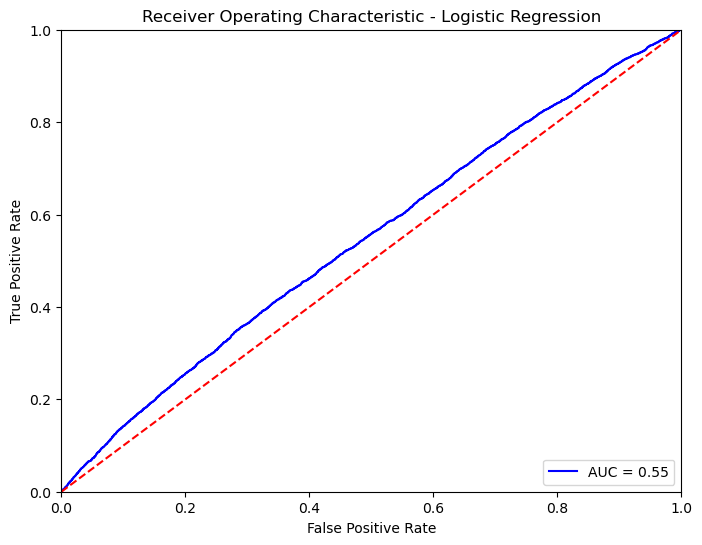

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


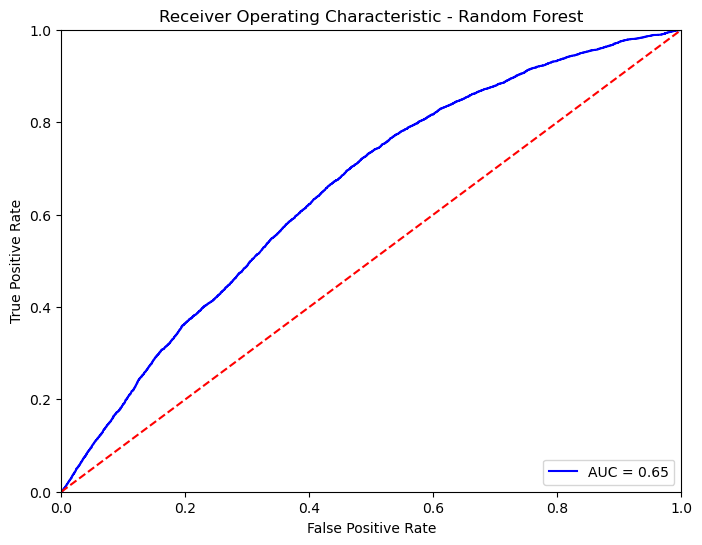

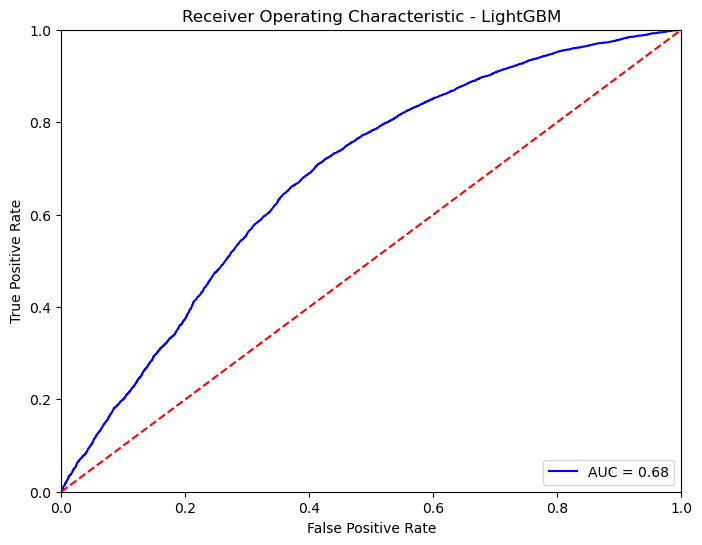

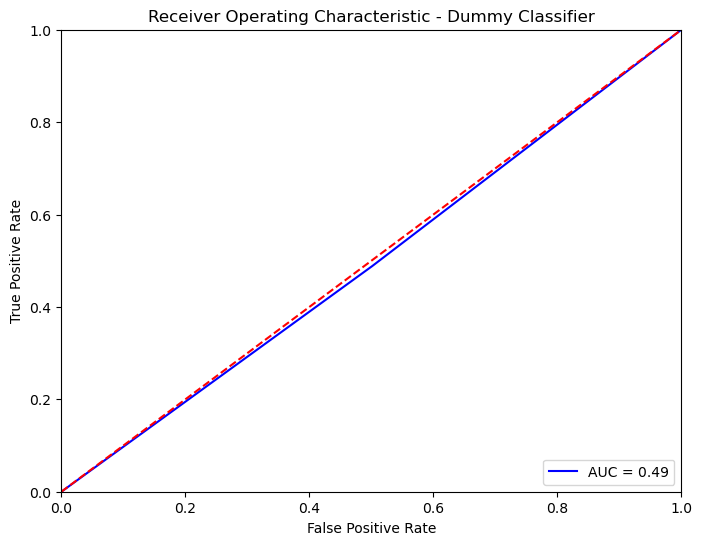

In [371]:
# Afficher la courbe AUC pour chaque modèle
plot_auc_curve(grid_search_logistic.best_estimator_, X_val, y_val, "Logistic Regression")
plot_auc_curve(grid_search_rf.best_estimator_, X_val, y_val, "Random Forest")
plot_auc_curve(grid_search_lgb.best_estimator_, X_val, y_val, "LightGBM")
plot_auc_curve(grid_search_dummy.best_estimator_, X_val, y_val, "Dummy Classifier")


In [373]:
# Créer le dictionnaire de résultats
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM', 'Dummy Classifier'],
    'Best AUC': [
        grid_search_logistic.best_score_,
        grid_search_rf.best_score_,
        grid_search_lgb.best_score_,
        grid_search_dummy.best_score_
    ],
    'Best F1 Score': [
        f1_score(y_val, grid_search_logistic.predict(X_val)),
        f1_score(y_val, grid_search_rf.predict(X_val)),
        f1_score(y_val, grid_search_lgb.predict(X_val)),
        f1_score(y_val, grid_search_dummy.predict(X_val))
    ],
    'Accuracy': [
        accuracy_score(y_val, grid_search_logistic.predict(X_val)),
        accuracy_score(y_val, grid_search_rf.predict(X_val)),
        accuracy_score(y_val, grid_search_lgb.predict(X_val)),
        accuracy_score(y_val, grid_search_dummy.predict(X_val))
    ],
    'Business Cost': [
        cost_logistic[0],
        cost_rf[0],
        cost_lgb[0],
        cost_dummy[0]
    ],
    'Fit Time (s)': [
        time_results['Logistic Regression - Fit Time'],
        time_results['Random Forest - Fit Time'],
        time_results['LightGBM - Fit Time'],
        time_results['Dummy Classifier - Fit Time']
    ],
    'Predict Time (s)': [
        time_results['Logistic Regression - Predict Time'],
        time_results['Random Forest - Predict Time'],
        time_results['LightGBM - Predict Time'],
        time_results['Dummy Classifier - Predict Time']
    ]
}

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results)
results_df


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Model,Best AUC,Best F1 Score,Accuracy,Business Cost,Fit Time (s),Predict Time (s)
0,Logistic Regression,0.647041,0.154621,0.563152,49610,224.868426,0.009357
1,Random Forest,0.716883,0.146478,0.861484,46796,402.185834,0.427655
2,LightGBM,0.709147,0.171568,0.845647,45502,13.894041,0.049382
3,Dummy Classifier,0.504151,0.136182,0.497724,53832,1.075544,0.004001


** Interprétation **
  *********
  

1. Évaluation des Modèles :
  
Logistic Regression
  
AUC (0.647) : Performances modérées sur la séparation des classes positives et négatives.
  
F1 Score (0.155) : Faible, indiquant que le modèle a du mal à équilibrer précision et rappel.
  
Accuracy (56.3%) : Meilleure que le Dummy Classifier, mais reste basse.
  
Business Cost (49,610) : Relativement élevé.
  
Temps d'ajustement (224.87 s) : Long, probablement dû à une optimisation hyperparamétrique.
  
Temps de prédiction (0.009 s) : Très rapide.
  
Random Forest
  
AUC (0.717) : Meilleure que Logistic Regression, indiquant une meilleure capacité de discrimination.

F1 Score (0.146) : Faible, ce qui indique que le modèle ne traite pas bien le déséquilibre des classes.

Accuracy (86.1%) : Haute, mais pourrait être trompeuse si les classes sont déséquilibrées.
    
Business Cost (46,796) : Meilleur que Logistic Regression, suggérant un impact positif.
    
Temps d'ajustement (402.19 s) : Le plus long, dû à la nature complexe de Random Forest.

Temps de prédiction (0.428 s) : Modérément rapide.
    
LightGBM
    
AUC (0.709) : Similaire à Random Forest, indiquant des performances comparables.
    
F1 Score (0.172) : Légèrement meilleur, ce qui suggère une meilleure gestion des classes déséquilibrées.
    
Accuracy (84.6%) : Haute, proche de Random Forest.
          
Business Cost (45,502) : Le plus bas, montrant que ce modèle est le plus rentable en termes de prise de décision.
    
Temps d'ajustement (13.89 s) : Très rapide, LightGBM est connu pour sa rapidité.

Temps de prédiction (0.049 s) : Très rapide, idéal pour des applications en temps réel.

Dummy Classifier

AUC (0.504) : À peine meilleur qu’un modèle aléatoire.

F1 Score (0.136) : Le plus bas, reflétant l'absence d'intelligence dans les prédictions.

Accuracy (49.8%) : Conforme à un choix aléatoire.

Business Cost (53,832) : Le plus élevé, montrant son inefficacité.

Temps d'ajustement/prédiction : Négligeable.

2. Observations Clés :

Meilleure performance globale : LightGBM

Offre un compromis idéal entre AUC, F1 Score, et coût commercial.

Très rapide pour l'entraînement et la prédiction.

Le plus rentable en termes de "Business Cost".

Random Forest :

Légèrement meilleur en AUC que LightGBM.

Prend beaucoup plus de temps à s'entraîner et à prédire.

Moins rentable que LightGBM en termes de coût commercial.

Logistic Regression :

Performances moyennes.

Moins adapté pour des données complexes ou des problèmes avec déséquilibre des classes.

Dummy Classifier :

Sert de baseline pour comparer les modèles.

Performances médiocres dans tous les aspects.

3. Recommandations :

Modèle recommandé : LightGBM

Équilibre entre performances, coût commercial, et rapidité.

Peut être amélioré par une optimisation hyperparamétrique supplémentaire.

En résumé, LightGBM semble le meilleur choix dans ce cas précis pour ses performances globales et son efficacité.

In [375]:
# Sérialisation des modèles

import joblib

# Enregistrer les meilleurs modèles après le GridSearchCV
joblib.dump(grid_search_logistic.best_estimator_, 'logistic_regression_model.pkl')
joblib.dump(grid_search_rf.best_estimator_, 'random_forest_model.pkl')
joblib.dump(grid_search_lgb.best_estimator_, 'lightgbm_model.pkl')
joblib.dump(grid_search_dummy.best_estimator_, 'dummy_classifier_model.pkl')


['dummy_classifier_model.pkl']

In [377]:
# Définir la fonction de coût métier

def business_cost_score(y_true, y_pred, cost_fp=1, cost_fn=10):
    # Calculer le nombre de faux positifs et faux négatifs
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    
    # Calculer le coût
    cost = cost_fp * fp + cost_fn * fn
    return cost


In [379]:
# Évaluer les coûts métier sur une gamme de seuils

def evaluate_costs(y_true, probabilities, thresholds):
    costs = []
    
    for threshold in thresholds:
        # Prédire les classes basées sur le seuil
        y_pred = (probabilities[:, 1] >= threshold).astype(int)
        cost = business_cost_score(y_true, y_pred)
        costs.append(cost)
    
    return costs

In [381]:
# Trouver le seuil optimal

# Obtenir les probabilités prédites pour le modèle LightGBM
best_model = grid_search_lgb.best_estimator_
probabilities = best_model.predict_proba(X_val)

# Définir la gamme de seuils
thresholds = np.arange(0, 1.01, 0.01)  # De 0 à 1 par pas de 0.01

# Évaluer les coûts métier
costs = evaluate_costs(y_val, probabilities, thresholds)

# Trouver le seuil qui minimise le coût métier
optimal_threshold = thresholds[np.argmin(costs)]
min_cost = min(costs)

print(f"Seuil optimal : {optimal_threshold}, Coût métier minimum : {min_cost}")


Seuil optimal : 0.24, Coût métier minimum : 38010


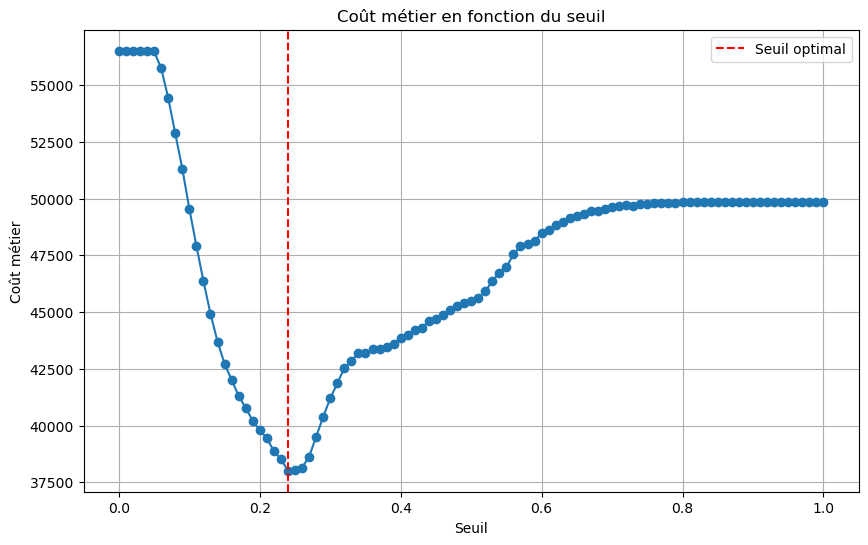

In [383]:
# Visualiser les résultats

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, marker='o')
plt.title('Coût métier en fonction du seuil')
plt.xlabel('Seuil')
plt.ylabel('Coût métier')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Seuil optimal')
plt.legend()
plt.grid()
plt.show()


** Interprétation du seuil optimal et du coût métier **
********

Seuil optimal (0.24) :

Application : Avec un seuil de 0.24, vous indiquez que vous classifiez une demande de crédit comme « accordée » si la probabilité estimée de remboursement est supérieure ou égale à 24 %. Cela signifie que vous êtes prêt à accepter un certain niveau de risque pour accorder des crédits, en espérant que la majorité des clients classés positifs rembourseront effectivement leur crédit.

Stratégie de gestion des risques : Ce seuil doit équilibrer la nécessité d'accorder des crédits pour générer des revenus et la nécessité de limiter les pertes dues à des défauts de paiement. Si le seuil est trop bas, vous pourriez approuver des demandes qui ne seront pas remboursées, entraînant des pertes. Si le seuil est trop élevé, vous pourriez refuser des clients qui auraient pu rembourser leurs crédits.

Coût métier minimum (38,010) :

Impact financier : Ce coût représente les pertes potentielles ou les coûts opérationnels associés à l'utilisation de ce seuil dans vos décisions de crédit. Cela peut inclure les défauts de paiement sur les crédits accordés aux clients jugés solvables, mais qui ne remboursent pas, ainsi que les coûts d’opération liés à la gestion des prêts en défaut.

Réflexion sur la rentabilité : En tant que société financière, il est essentiel de savoir si ce coût est acceptable par rapport aux revenus générés par les intérêts sur les crédits accordés. Si 38,010 € représente un niveau de perte que l'entreprise peut gérer tout en restant rentable, cela peut être un bon point de départ. Cependant, si ce coût est trop élevé, il pourrait être nécessaire d'ajuster le modèle ou le seuil.

2024/11/12 12:08:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


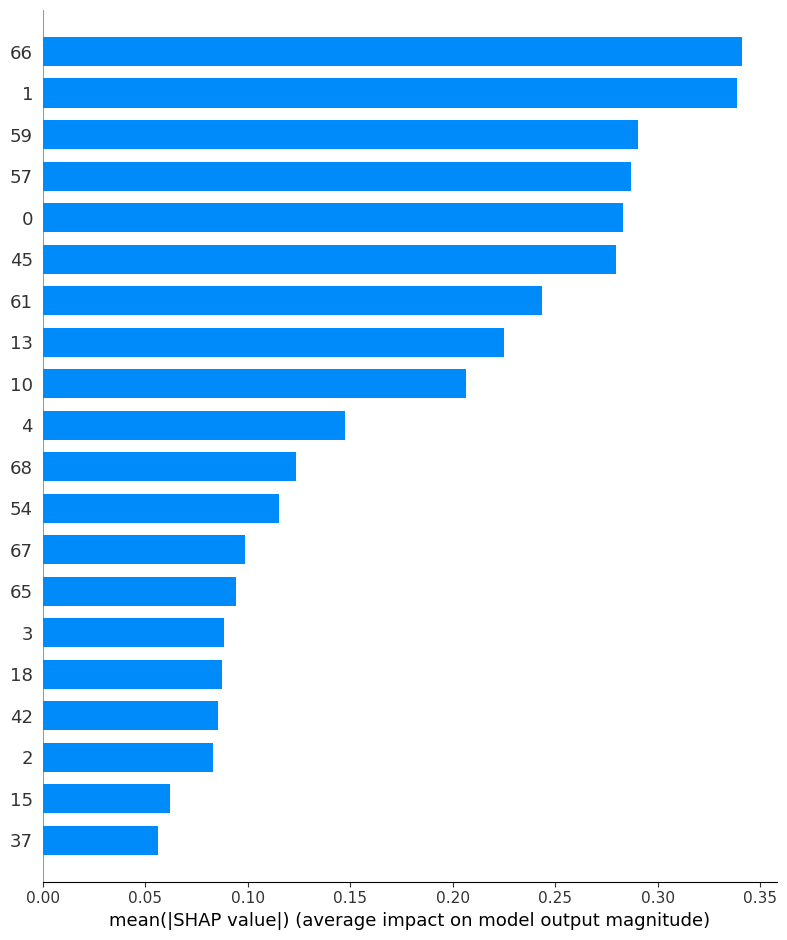

Run ID: 2d927f813cc943caa3e8c851399dd7aa


<Figure size 640x480 with 0 Axes>

In [385]:
import pandas as pd

# Fonction pour afficher l'importance des features et l'enregistrer comme artefact
def plot_feature_importance_with_mlflow(model, X, run_id):
    # Vérifiez que le modèle est bien entraîné, ici en prenant directement 'grid_search_lgb'
    best_model = model.best_estimator_.named_steps['classifier']  # Le modèle LightGBM

    # Calcul des valeurs SHAP
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X)

    # Résumé de l'importance des features (affichage avec les noms de features)
    shap.summary_plot(shap_values, X, plot_type="bar")

    # Sauvegarder le plot SHAP comme image
    shap_summary_file = "shap_summary_plot.png"
    plt.savefig(shap_summary_file)
    
    # Loguer l'artefact dans MLflow
    mlflow.log_artifact(shap_summary_file)

# Démarrer un run MLflow
with mlflow.start_run() as run:
    # Si vous avez utilisé un GridSearchCV, utilisez 'grid_search_lgb' pour obtenir le meilleur modèle
    best_model = grid_search_lgb.best_estimator_.named_steps['classifier']
    
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(best_model, "model")
    
    # Log des métriques (par exemple, accuracy)
    accuracy = accuracy_score(y_val, grid_search_lgb.predict(X_val))
    mlflow.log_metric("accuracy", accuracy)
    
    # Créer un DataFrame filtré en excluant TARGET, SK_ID_CURR et CODE_GENDER
    columns_to_exclude = ['TARGET', 'SK_ID_CURR', 'CODE_GENDER']
    
    # Si X_train est un numpy.ndarray, nous devons d'abord le convertir en DataFrame
    if isinstance(X_train, np.ndarray):
        X_train_df = pd.DataFrame(X_train)  # Convertir X_train en DataFrame Pandas

    # Appliquer le filtrage des colonnes
    X_train_filtered = X_train_df.loc[:, ~X_train_df.columns.isin(columns_to_exclude)]
    
    # Log des artefacts (SHAP plot) avec X_train_filtered
    plot_feature_importance_with_mlflow(grid_search_lgb, X_train_filtered, run.info.run_id)
    
    # Log d'autres artefacts si nécessaire
    mlflow.log_artifact("other_file.txt")

    print(f"Run ID: {run.info.run_id}")


2024/11/12 12:09:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


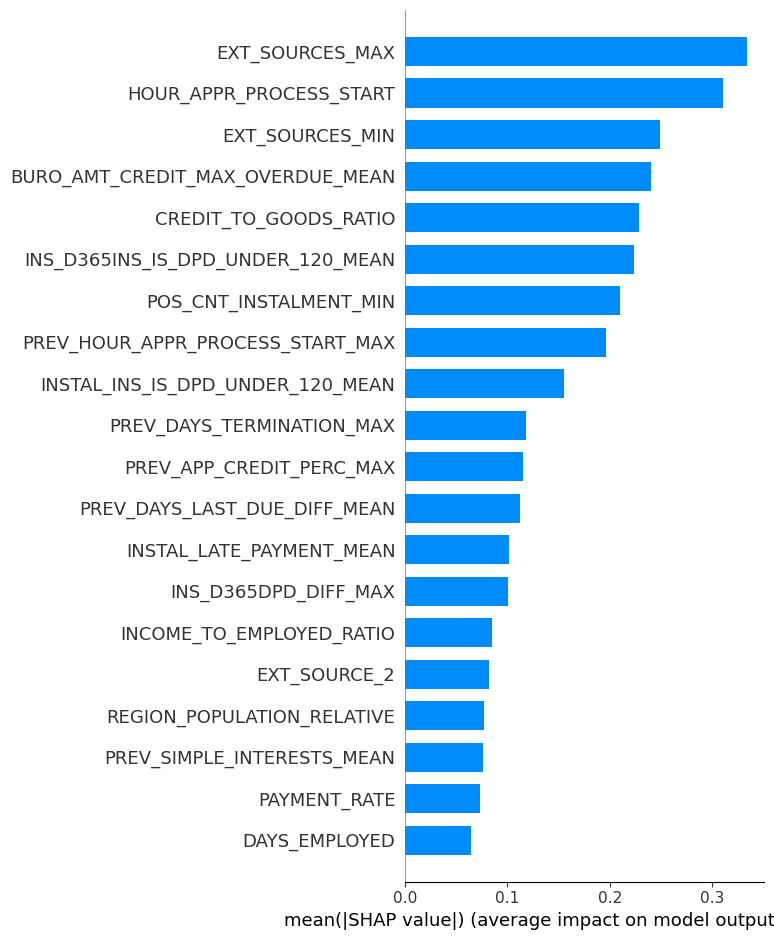

Run ID: d4e9c223adeb4033b856501f3a92766f


<Figure size 640x480 with 0 Axes>

In [387]:
# Assurez-vous que le run précédent est bien terminé
mlflow.end_run()

# Démarrer un nouveau run MLflow
with mlflow.start_run() as run:
    # Si vous avez utilisé un GridSearchCV, utilisez 'grid_search_lgb' pour obtenir le meilleur modèle
    best_model = grid_search_lgb.best_estimator_.named_steps['classifier']
    
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(best_model, "model")
    
    # Log des métriques (par exemple, accuracy)
    accuracy = accuracy_score(y_val, grid_search_lgb.predict(X_val))
    mlflow.log_metric("accuracy", accuracy)
    
    # Exclure les colonnes TARGET, SK_ID_CURR, et CODE_GENDER avant de créer le DataFrame
    columns_to_exclude = ['TARGET', 'SK_ID_CURR', 'CODE_GENDER']
    
    # Assurez-vous que vous avez le bon nombre de colonnes dans X_train
    X_train_filtered = data_cleaned.drop(columns=columns_to_exclude).iloc[:len(X_train)].values

    # Convertir X_train_filtered en DataFrame en utilisant les colonnes restantes
    X_train_df = pd.DataFrame(X_train_filtered, columns=[col for col in data_cleaned.columns if col not in columns_to_exclude])
    
    # Log des artefacts (SHAP plot)
    plot_feature_importance_with_mlflow(grid_search_lgb, X_train_df, run.info.run_id)
    
    # Log d'autres artefacts si nécessaire
    mlflow.log_artifact("other_file.txt")

    print(f"Run ID: {run.info.run_id}")


In [389]:
# Vérifiez les colonnes dans data_cleaned
print(data_cleaned.columns)

Index(['SK_ID_CURR', 'TARGET', 'EXT_SOURCES_MIN', 'EXT_SOURCES_MAX',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH',
       'APPS_EXT_SOURCE_STD', 'DAYS_REGISTRATION', 'INSTAL_AMT_INSTALMENT_MAX',
       'DAYS_ID_PUBLISH', 'PAYMENT_RATE', 'INSTAL_AMT_INSTALMENT_MEAN',
       'PREV_AMT_ANNUITY_MAX', 'INS_D365DPD_DIFF_MAX',
       'PREV_DAYS_DECISION_MEAN', 'INCOME_TO_EMPLOYED_RATIO', 'INSTAL_DBD_VAR',
       'BURO_DAYS_CREDIT_MEAN', 'INSTAL_AMT_INSTALMENT_MIN',
       'PREV_SIMPLE_INTERESTS_MEAN', 'ANNUITY_INCOME_PERC',
       'BURO_DAYS_CREDIT_ENDDATE_MIN', 'BURO_DEBT_CREDIT_DIFF_MAX',
       'BURO_DEBT_CREDIT_DIFF_MIN', 'INCOME_CREDIT_PERC',
       'INS_D365AMT_INSTALMENT_MEAN', 'DAYS_LAST_PHONE_CHANGE',
       'BURO_BUREAU_CREDIT_FACT_DIFF_MAX', 'INSTAL_DBD_SUM',
       'PREV_CREDIT_TO_ANNUITY_RATIO_MEAN', 'INCOME_PER_PERSON',
       'PREV_AMT_GOODS_PRICE_MIN', 'INSTAL_DBD_MEAN',
       'PREV_APP_CREDIT_PERC_MEAN', 'ACTIVE_DEBT_CREDIT_DIFF_MIN',
       'AMT_CRED

C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


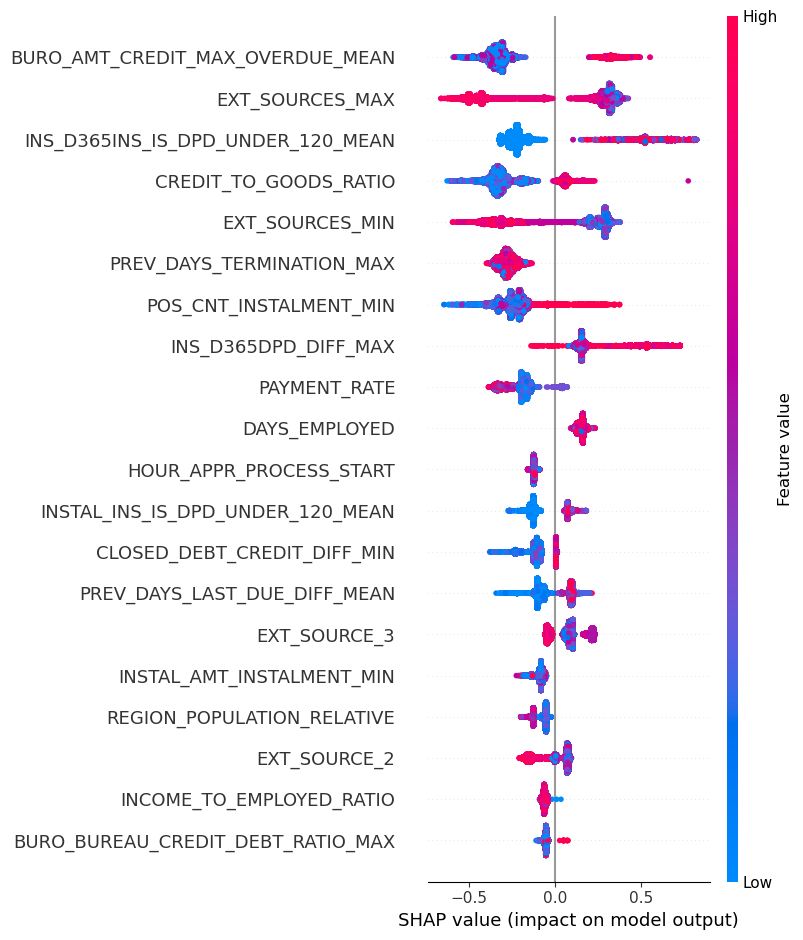

In [391]:
# Assurez-vous que X_val est un DataFrame avec des noms de colonnes
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Créer un explainer basé sur LightGBM (ou votre modèle final)
explainer = shap.TreeExplainer(grid_search_lgb.best_estimator_.named_steps['classifier'])

# Calculer les valeurs SHAP pour les données de validation
shap_values = explainer.shap_values(X_val_df)

# Graphique d'importance des features global
shap.summary_plot(shap_values, X_val_df, feature_names=X.columns)

In [393]:
# Utilisez TreeExplainer de SHAP pour le modèle LightGBM
explainer = shap.TreeExplainer(grid_search_lgb.best_estimator_.named_steps['classifier'])

# Calculer les valeurs SHAP pour le jeu de validation
shap_values = explainer.shap_values(X_val_df)

client_idx = 10  # Par exemple, le 10ème client

# Vérifiez si shap_values est une liste (pour la classification binaire)
if isinstance(shap_values, list):
    # Utilisez shap_values pour la deuxième classe (classe 1 si binaire)
    class_idx = 1

    # Visualisation de l'importance locale pour le client donné avec SHAP
    shap.force_plot(
        explainer.expected_value[class_idx],  # Utilisez expected_value pour la classe 1
        shap_values[class_idx][client_idx, :],  # shap_values pour la classe 1
        X_val_df.iloc[client_idx, :]  # Données du client
    )
else:
    # Visualisation de l'importance locale pour le client donné (classification mono-classe)
    shap.force_plot(
        explainer.expected_value,  # expected_value si une seule classe
        shap_values[client_idx, :],  # shap_values pour le client donné
        X_val_df.iloc[client_idx, :]  # Données du client
    )

C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [395]:
import shap
shap.initjs()

In [397]:
# Visualisation de l'importance locale pour le client donné
shap.force_plot(
    explainer.expected_value,  # Pas d'indexation par classe pour expected_value
    shap_values[client_idx, :],  # Pas d'indexation par classe pour shap_values
    X_val_df.iloc[client_idx, :]  # Données du client
)

In [408]:
# Fonction pour expliquer et sauvegarder l'importance locale avec SHAP
def explain_with_shap_and_log(explainer, shap_values, X_val_df, client_idx, run_id):
    # Vérifiez si shap_values est une liste (pour la classification binaire)
    if isinstance(shap_values, list):
        class_idx = 1  # Pour la deuxième classe (par exemple, "Prospect")

        # Visualisation de l'importance locale pour le client donné
        shap_fig = shap.force_plot(
            explainer.expected_value[class_idx],  # Utilisez expected_value pour la classe 1
            shap_values[class_idx][client_idx, :],  # shap_values pour la classe 1
            X_val_df.iloc[client_idx, :]  # Données du client
        )
    else:
        # Si shap_values n'est pas une liste, c'est probablement une tâche de régression ou une classification mono-classe
        shap_fig = shap.force_plot(
            explainer.expected_value,  # Utilisation directe si une seule classe
            shap_values[client_idx, :],  # Pas d'indexation par classe
            X_val_df.iloc[client_idx, :]  # Données du client
        )

    # Sauvegarde de la visualisation SHAP en tant que fichier image
    shap_image_file = "shap_force_plot.png"
    shap.save_html(shap_image_file, shap_fig)  # Enregistre l'explication sous forme de fichier HTML

    # Loguer l'explication SHAP dans MLflow
    mlflow.log_artifact(shap_image_file)
    print(f"SHAP explanation saved as artifact: {shap_image_file}")

# Démarrer un run MLflow
with mlflow.start_run() as run:
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Log des métriques (par exemple, accuracy)
    accuracy = accuracy_score(y_val, grid_search_lgb.predict(X_val))
    mlflow.log_metric("accuracy", accuracy)

       # Exclure les colonnes TARGET, SK_ID_CURR, et CODE_GENDER avant de créer le DataFrame
    columns_to_exclude = ['TARGET', 'SK_ID_CURR', 'CODE_GENDER']
    
    # Assurez-vous que vous avez le bon nombre de colonnes dans X_train
    X_train_filtered = data_cleaned.drop(columns=columns_to_exclude).iloc[:len(X_train)].values
    # Exclure les mêmes colonnes pour X_val et vous assurer que X_val a la même taille que X_val
    X_val_filtered = data_cleaned.drop(columns=columns_to_exclude).iloc[:len(X_val)].values

    # Convertir X_train_filtered en DataFrame en utilisant les colonnes restantes
    X_train_df = pd.DataFrame(X_train_filtered, columns=[col for col in data_cleaned.columns if col not in columns_to_exclude])
    X_val_df = pd.DataFrame(X_val_filtered, columns=[col for col in data_cleaned.columns if col not in columns_to_exclude])  # Pareil pour X_val
    
    # Initialisation de SHAP avec l'explainer
    explainer = shap.TreeExplainer(grid_search_lgb.best_estimator_.named_steps['classifier'])
    shap_values = explainer.shap_values(X_val_df)
    
    # Expliquer une instance (par exemple, le 10ème client) et enregistrer la visualisation
    explain_with_shap_and_log(explainer, shap_values, X_val_df, client_idx=10, run_id=run.info.run_id)
    
    # Log d'autres artefacts si nécessaire
    mlflow.log_artifact("other_file.txt")

    print(f"Run ID: {run.info.run_id}")

2024/11/12 12:18:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SHAP explanation saved as artifact: shap_force_plot.png
Run ID: fe910463212d41289ff1782b23aeaa00


C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [410]:
import mlflow
import mlflow.lightgbm

# Enregistrez le modèle dans MLflow
with mlflow.start_run():
    # Log de l'entraînement du modèle
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Log des paramètres du modèle (optionnel)
    mlflow.log_param("max_depth", grid_search_lgb.best_params_['classifier__max_depth'])

    # Log des métriques (optionnel)
    mlflow.log_metric("accuracy", accuracy_score(y_val, grid_search_lgb.predict(X_val)))

2024/11/12 12:20:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/11/12 12:20:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


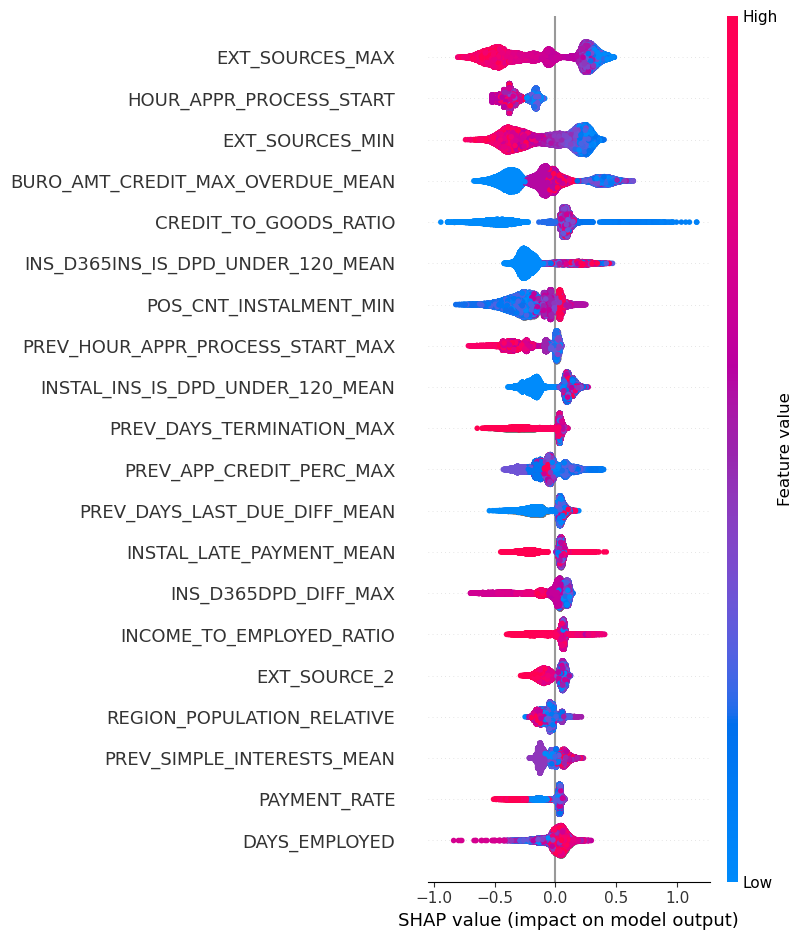

In [412]:
# Créer un fichier texte avant de l'enregistrer
with open("other_file.txt", "w") as f:
    f.write("Ceci est un fichier texte exemple pour l'enregistrement dans MLflow.")

# Log du fichier texte dans MLflow
with mlflow.start_run():
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Créer une visualisation SHAP
    shap.initjs()  # Initialiser les éléments JS pour SHAP
    shap.summary_plot(shap_values, X_val_df, feature_names=X_val_df.columns, show=False)  # Visualisation SHAP
    
    # Enregistrer la visualisation SHAP
    plt.savefig("shap_summary_plot.png")
    
    # Log de la visualisation SHAP dans MLflow
    mlflow.log_artifact("shap_summary_plot.png")
    
    # Log du fichier texte
    mlflow.log_artifact("other_file.txt")


In [414]:
from lime.lime_tabular import LimeTabularExplainer

# Assurez-vous que X_train est un DataFrame avec des noms de colonnes
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Initialisation de l'explainer LIME
explainer = LimeTabularExplainer(
    X_train_df.values, 
    feature_names=X_train_df.columns, 
    class_names=['Non Prospect', 'Prospect'], 
    discretize_continuous=True
)

# Sélection d'une instance à expliquer
client_idx = 10  # Par exemple, le 10ème client
exp = explainer.explain_instance(
    X_val_df.iloc[client_idx].values, 
    grid_search_lgb.predict_proba, 
    num_features=10
)

# Visualisation de l'explication locale
exp.show_in_notebook(show_all=False)

In [420]:
from lime.lime_tabular import LimeTabularExplainer
import mlflow
import mlflow.lightgbm
from sklearn.metrics import accuracy_score

# Fonction pour expliquer une instance avec LIME et sauvegarder l'explication comme artefact
def explain_with_lime_and_log(model, X_train, X_val, client_idx, run_id):
    # Initialisation de LIME sans discrétisation
    explainer = LimeTabularExplainer(
        X_train.values, 
        feature_names=X_train.columns, 
        class_names=['Non Prospect', 'Prospect'], 
        discretize_continuous=False  # Désactivez la discrétisation
    )

    # Sélection d'une instance à expliquer
    exp = explainer.explain_instance(
        X_val.iloc[client_idx].values, 
        model.predict_proba, 
        num_features=10
    )

    # Visualisation de l'explication locale
    exp_image_file = "lime_explanation.png"
    exp.save_to_file(exp_image_file)
    
    # Loguer l'explication LIME dans MLflow
    mlflow.log_artifact(exp_image_file)
    print(f"LIME explanation saved as artifact: {exp_image_file}")

# Démarrer un run MLflow
with mlflow.start_run() as run:
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Log des métriques (par exemple, accuracy)
    accuracy = accuracy_score(y_val, grid_search_lgb.predict(X_val))
    mlflow.log_metric("accuracy", accuracy)
    
    # Convertir X_train_filtered en DataFrame en utilisant les colonnes restantes
    X_train_df = pd.DataFrame(X_train_filtered, columns=[col for col in data_cleaned.columns if col not in columns_to_exclude])
    X_val_df = pd.DataFrame(X_val_filtered, columns=[col for col in data_cleaned.columns if col not in columns_to_exclude])  # Pareil pour X_val
    
    # Expliquer une instance (par exemple, le 10ème client) et enregistrer la visualisation
    explain_with_lime_and_log(grid_search_lgb, X_train_df, X_val_df, client_idx=10, run_id=run.info.run_id)
    
    # Log d'autres artefacts si nécessaire
    mlflow.log_artifact("other_file.txt")

    print(f"Run ID: {run.info.run_id}")


2024/11/12 12:25:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LIME explanation saved as artifact: lime_explanation.png
Run ID: 591c8ca08ffb46dab9c039035ca5e390


In [131]:
# !pip install lime

In [426]:
# Assurez-vous que X_train est un DataFrame avec des noms de colonnes   # à vérifier puis supprimer
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Initialisation de l'explainer LIME
explainer = LimeTabularExplainer(
    X_train_df.values, 
    feature_names=X_train_df.columns, 
    class_names=['Non Prospect', 'Prospect'], 
    discretize_continuous=True
)

# Sélection d'une instance à expliquer
client_idx = 10  # Par exemple, le 10ème client
exp = explainer.explain_instance(
    X_val_df.iloc[client_idx].values, 
    grid_search_lgb.predict_proba, 
    num_features=10
)

# Sauvegarder l'explication LIME en tant que fichier HTML
lime_html_path = "lime_explanation.html"
exp.save_to_file(lime_html_path)

# Enregistrer le modèle et l'explication dans MLflow
with mlflow.start_run():
    # Enregistrer le modèle dans MLflow
    mlflow.sklearn.log_model(grid_search_lgb.best_estimator_, "model")
    
    # Enregistrer l'explication LIME en tant qu'artefact
    mlflow.log_artifact(lime_html_path)
    
    # Vous pouvez aussi loguer d'autres informations (par exemple, des métriques ou des fichiers)
    mlflow.log_param("Client Index", client_idx)
    mlflow.log_param("Features Explained", 10)  # Exemple de paramètre

2024/11/12 12:29:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [422]:
# Sauvegarde des modèles shapely pour le dashboard

# Utilisez TreeExplainer de SHAP pour le modèle LightGBM
explainer = shap.TreeExplainer(grid_search_lgb.best_estimator_.named_steps['classifier'])

# Calculer les valeurs SHAP pour le jeu de validation
shap_values = explainer.shap_values(X_val_df)

# Sauvegarder l'explainer et les valeurs SHAP avec joblib
joblib.dump(explainer, 'shap_explainer.pkl')
joblib.dump(shap_values, 'shap_values.pkl')

C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


['shap_values.pkl']

In [428]:
# Chargement des valeurs SHAP

# Charger l'explainer et les valeurs SHAP depuis les fichiers
loaded_explainer = joblib.load('shap_explainer.pkl')
loaded_shap_values = joblib.load('shap_values.pkl')

# Utiliser l'explainer chargé pour générer des visualisations
client_idx = 10  # Par exemple, le 10ème client

# Vérifier si shap_values est une liste (pour la classification binaire)
if isinstance(loaded_shap_values, list):
    class_idx = 1  # Utilisez la classe 1 si classification binaire
    shap.force_plot(
        loaded_explainer.expected_value[class_idx],
        loaded_shap_values[class_idx][client_idx, :],
        X_val_df.iloc[client_idx, :]
    )
else:
    shap.force_plot(
        loaded_explainer.expected_value,
        loaded_shap_values[client_idx, :],
        X_val_df.iloc[client_idx, :]
    )


In [430]:
# Sauvegarder les prédictions et les vraies étiquettes dans un fichier CSV
predictions = grid_search_lgb.predict(X_val)
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Label': predictions
})
results_df.to_csv('predictions_vs_true_labels.csv', index=False)
